<a href="https://colab.research.google.com/github/kennc05/household_electricity_forecasting/blob/main/1.%20Data%20pre%20processing%20and%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
# to access google drive folder
from google.colab import drive
drive.mount("/content/drive") # When you run this you'll be prompted for a token - follow the link to generate this.

full_path = "/content/drive/MyDrive/Kenn @Newcastle Uni/20-21 - Year 3/CSC3032: Dissertation/Code/London Smart Meters/Datasets"

# import libraries needed 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import mutual_info_regression  
from sklearn.feature_selection import SelectKBest
import seaborn as sns


pd.options.display.max_columns = 60
pd.options.display.max_colwidth = 500

#Feature scaling / one hot encoding questions
#https://datascience.stackexchange.com/questions/95071/should-i-do-one-hot-encoding-before-feature-selection-and-how-should-i-perform-f
#https://stats.stackexchange.com/questions/440372/feature-selection-before-or-after-encoding



Mounted at /content/drive


## 1. Pre-processing of individual household consumption data


### 1.1 Organise Daily consumption 

In [ ]:
#Load the daily consumption dataset 
daily_consumption = pd.read_csv(full_path+'/daily/daily_dataset.csv')

#Get column description
daily_consumption.columns

Index(['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max',
       'energy_count', 'energy_std', 'energy_sum', 'energy_min'],
      dtype='object')

In [ ]:
daily_consumption.head()

LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15         0.4850     0.432045       0.868   
1  MAC000131  2011-12-16         0.1415     0.296167       1.116   
2  MAC000131  2011-12-17         0.1015     0.189812       0.685   
3  MAC000131  2011-12-18         0.1140     0.218979       0.676   
4  MAC000131  2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066

In [ ]:
#Check the length and shape of data

daily_consumption.shape

(3510433, 9)

In [ ]:
#Change day into readable format
daily_consumption['day']=  pd.to_datetime(daily_consumption['day'],format='%Y-%m-%d')#.dt.date

#Reset index so that it is ordered by day rather than by LCLid
daily_consumption = daily_consumption.sort_values(by=['day']).reset_index(drop=True)

#Keep only relevant columns which is day and energy_sum
daily_consumption = daily_consumption[['LCLid', 'day', 'energy_sum']]

#Add calendar attributes as separate features for use later on 
daily_consumption['day_of_week'] = daily_consumption.day.dt.dayofweek
daily_consumption['day_of_month'] = daily_consumption.day.dt.day
daily_consumption['month'] = daily_consumption.day.dt.month

#View new data structure
daily_consumption.head(10)

LCLid        day  energy_sum  day_of_week  day_of_month  month
0  MAC000149 2011-11-23       2.287            2            23     11
1  MAC000154 2011-11-23       5.798            2            23     11
2  MAC000156 2011-11-23       6.523            2            23     11
3  MAC000150 2011-11-23       9.254            2            23     11
4  MAC000147 2011-11-23       3.036            2            23     11
5  MAC000146 2011-11-23       5.619            2            23     11
6  MAC000157 2011-11-23       7.408            2            23     11
7  MAC000152 2011-11-23       5.969            2            23     11
8  MAC000151 2011-11-23       3.273            2            23     11
9  MAC000145 2011-11-23       8.952            2            23     11

### 1.2 Organise ACORN and Tariff information

In [ ]:
household_information = pd.read_csv(full_path+'/daily/informations_households.csv')

household_information.head()

LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0

In [ ]:
household_information.columns

Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')

In [ ]:
household_information.shape

(5566, 5)

In [ ]:
household_information.Acorn.unique()

array(['ACORN-', 'ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'ACORN-Q',
       'ACORN-U'], dtype=object)

In [ ]:
household_information.Acorn_grouped.unique()

array(['ACORN-', 'Affluent', 'Comfortable', 'Adversity', 'ACORN-U'],
      dtype=object)

In [ ]:
#https://datagy.io/sklearn-one-hot-encode/

#Get the relevant columns only 
household_information= household_information[['LCLid', 'stdorToU', 'Acorn_grouped']]

#Use make_column_transformer to make the categorical column into one hot encoding 
onehot_transformer = make_column_transformer((OneHotEncoder(), ['Acorn_grouped']), remainder='passthrough', verbose_feature_names_out=False)

#Apply one hot encoding to the columns 
transformed = onehot_transformer.fit_transform(household_information)

#Replace the existing household_information dataframe with the transformed one
household_information = pd.DataFrame(transformed, columns=onehot_transformer.get_feature_names_out())

#Re-order the dataframe to so that LCLid is first
household_information = household_information[['LCLid', 'stdorToU', 'Acorn_grouped_ACORN-', 'Acorn_grouped_ACORN-U',
                                               'Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
                                               'Acorn_grouped_Comfortable']]

household_information.head()

LCLid stdorToU Acorn_grouped_ACORN- Acorn_grouped_ACORN-U  \
0  MAC005492      ToU                  1.0                   0.0   
1  MAC001074      ToU                  1.0                   0.0   
2  MAC000002      Std                  0.0                   0.0   
3  MAC003613      Std                  0.0                   0.0   
4  MAC003597      Std                  0.0                   0.0   

  Acorn_grouped_Adversity Acorn_grouped_Affluent Acorn_grouped_Comfortable  
0                     0.0                    0.0                       0.0  
1                     0.0                    0.0                       0.0  
2                     0.0                    1.0                       0.0  
3                     0.0                    1.0                       0.0  
4                     0.0                    1.0                       0.0

### 1.3 Organise daily weather 

In [ ]:
daily_weather = pd.read_csv(full_path + '/daily/weather_daily_darksky.csv')

daily_weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime',
       'moonPhase'],
      dtype='object')

In [ ]:
daily_weather.head()

temperatureMax   temperatureMaxTime  windBearing                 icon  \
0           11.96  2011-11-11 23:00:00          123                  fog   
1            8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232                 wind   
4            8.22  2011-12-24 23:00:00          252  partly-cloudy-night   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   
4      2.79  2011-12-24 07:00:00        0.37       4.46   1028.17   

  apparentTemperatureMinTime  apparentTemperatureHigh precipType  visibility  \
0        2011-11-11 07:00:00                    10.87       rain        3.30   
1        2011-12-11 02:00:00                     5.62       rain       12.09   
2        2011-12-27 22:00:00                    10.33       rain       13.39   
3        2011-12-02 07:00:00                     5.33       rain       11.89   
4        2011-12-24 07:00:00                     5.02       rain       13.16   

   humidity apparentTemperatureHighTime  apparentTemperatureLow  \
0      0.95         2011-11-11 19:00:00                   10.87   
1      0.88         2011-12-11 19:00:00                   -0.64   
2      0.74         2011-12-27 14:00:00                    5.52   
3      0.87         2011-12-02 12:00:00                    3.26   
4      0.80         2011-12-24 15:00:00                    4.37   

   apparentTemperatureMax  uvIndex                 time           sunsetTime  \
0                   11.96      1.0  2011-11-11 00:00:00  2011-11-11 16:19:21   
1                    5.72      1.0  2011-12-11 00:00:00  2011-12-11 15:52:53   
2                   10.33      0.0  2011-12-27 00:00:00  2011-12-27 15:57:56   
3                    5.33      1.0  2011-12-02 00:00:00  2011-12-02 15:56:17   
4                    5.32      1.0  2011-12-24 00:00:00  2011-12-24 15:55:55   

   temperatureLow  temperatureMin  temperatureHigh          sunriseTime  \
0           10.87            8.85            10.87  2011-11-11 07:12:14   
1            3.09            2.48             8.59  2011-12-11 07:57:02   
2            8.03            8.03            10.33  2011-12-27 08:07:06   
3            6.33            2.56             7.36  2011-12-02 07:46:09   
4            7.45            3.17             7.93  2011-12-24 08:06:15   

   temperatureHighTime          uvIndexTime  \
0  2011-11-11 19:00:00  2011-11-11 11:00:00   
1  2011-12-11 14:00:00  2011-12-11 12:00:00   
2  2011-12-27 14:00:00  2011-12-27 00:00:00   
3  2011-12-02 12:00:00  2011-12-02 10:00:00   
4  2011-12-24 15:00:00  2011-12-24 13:00:00   

                                                  summary  \
0                                  Foggy until afternoon.   
1                       Partly cloudy throughout the day.   
2                       Mostly cloudy throughout the day.   
3  Partly cloudy throughout the day and breezy overnight.   
4                       Mostly cloudy throughout the day.   

    temperatureLowTime  apparentTemperatureMin apparentTemperatureMaxTime  \
0  2011-11-11 19:00:00                    6.48        2011-11-11 23:00:00   
1  2011-12-12 07:00:00                    0.11        2011-12-11 20:00:00   
2  2011-12-27 23:00:00                    5.59        2011-12-27 02:00:00   
3  2011-12-02 19:00:00                    0.46        2011-12-02 12:00:00   
4  2011-12-24 19:00:00                   -0.51        2011-12-24 23:00:00   

  apparentTemperatureLowTime  moonPhase  
0        2011-11-11 19:00:00       0.52  
1        2011-12-12 08:00:00       0.53  
2        2011-12-28 00:00:00       0.10  
3        2011-12-02 19:00:00      

In [ ]:
daily_weather.shape

(882, 32)

In [ ]:
# convert time into date time format that python can read
daily_weather['day']=  pd.to_datetime(daily_weather['time'])
daily_weather['day']=  pd.to_datetime(daily_weather['day'],format='%Y%m%d').dt.date

#Keep only relevant columns 
daily_weather = daily_weather[['day', 'icon', 'temperatureLow', 'temperatureHigh', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 
                               'visibility', 'humidity', 'uvIndex', 'moonPhase']]

#Reset index so that dataframe is in order by day 
daily_weather = daily_weather.sort_values(by=['day']).reset_index(drop=True)

#Rename icon to weather type
daily_weather.rename(columns={'icon':'weather_type'}, inplace = True)

daily_weather.head(10)

day         weather_type  temperatureLow  temperatureHigh  dewPoint  \
0  2011-11-01    partly-cloudy-day            8.88            15.57     10.13   
1  2011-11-02  partly-cloudy-night           13.99            15.06     10.23   
2  2011-11-03    partly-cloudy-day           12.52            17.41     13.39   
3  2011-11-04                  fog           10.17            15.54     12.03   
4  2011-11-05                  fog            9.46            13.94     10.96   
5  2011-11-06    partly-cloudy-day           10.17            11.85      7.48   
6  2011-11-07                  fog            9.67            12.78      9.59   
7  2011-11-08                  fog            9.73            10.57      9.12   
8  2011-11-09    partly-cloudy-day           10.26            15.00     10.09   
9  2011-11-10                  fog            8.85            13.71     10.44   

   cloudCover  windSpeed  pressure  visibility  humidity  uvIndex  moonPhase  
0        0.36       2.45   1009.46       12.68      0.84      1.0       0.21  
1        0.39       4.39   1004.79       11.83      0.87      1.0       0.24  
2        0.52       3.99    993.40       12.15      0.89      1.0       0.27  
3        0.50       2.62    995.54       10.69      0.91      1.0       0.31  
4        0.65       2.70   1007.39        4.60      0.92      1.0       0.34  
5        0.77       4.77   1021.96       11.76      0.81      1.0       0.37  
6        0.82       3.90   1020.81        5.89      0.89      1.0       0.40  
7        0.83       2.40   1014.61        4.31      0.92      1.0       0.43  
8        0.57       2.74   1015.59        9.85      0.90      1.0       0.46  
9        0.34       2.66   1017.41        6.41      0.92      1.0       0.49

In [ ]:
#Use make_column_transformer to make the categorical column into one hot encoding 
onehot_transformer = make_column_transformer((OneHotEncoder(), ['weather_type']), remainder='passthrough', verbose_feature_names_out=False)

#Apply one hot encoding to the columns 
transformed = onehot_transformer.fit_transform(daily_weather)

#Replace the existing household_information dataframe with the transformed one
daily_weather = pd.DataFrame(transformed, columns=onehot_transformer.get_feature_names_out())

#Re-order for better structure and clarity 
daily_weather = daily_weather[['day', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day', 
       'weather_type_cloudy', 'weather_type_fog', 'weather_type_partly-cloudy-day', 
       'weather_type_partly-cloudy-night', 'weather_type_wind']]

In [ ]:
daily_weather.head()

day temperatureLow temperatureHigh dewPoint cloudCover windSpeed  \
0  2011-11-01           8.88           15.57    10.13       0.36      2.45   
1  2011-11-02          13.99           15.06    10.23       0.39      4.39   
2  2011-11-03          12.52           17.41    13.39       0.52      3.99   
3  2011-11-04          10.17           15.54    12.03        0.5      2.62   
4  2011-11-05           9.46           13.94    10.96       0.65       2.7   

  pressure visibility humidity uvIndex moonPhase weather_type_clear-day  \
0  1009.46      12.68     0.84     1.0      0.21                    0.0   
1  1004.79      11.83     0.87     1.0      0.24                    0.0   
2    993.4      12.15     0.89     1.0      0.27                    0.0   
3   995.54      10.69     0.91     1.0      0.31                    0.0   
4  1007.39        4.6     0.92     1.0      0.34                    0.0   

  weather_type_cloudy weather_type_fog weather_type_partly-cloudy-day  \
0                 0.0              0.0                            1.0   
1                 0.0              0.0                            0.0   
2                 0.0              0.0                            1.0   
3                 0.0              1.0                            0.0   
4                 0.0              1.0                            0.0   

  weather_type_partly-cloudy-night weather_type_wind  
0                              0.0               0.0  
1                              1.0               0.0  
2                              0.0               0.0  
3                              0.0               0.0  
4                              0.0               0.0

In [ ]:
#Check daily weather date range 
daily_weather['day'] = pd.to_datetime(daily_weather['day'],format='%Y-%m-%d')

print(str(daily_weather['day'].dt.date.min()) + ' to ' +str(daily_weather['day'].dt.date.max()))

2011-11-01 to 2014-03-30


In [ ]:
#Check weather on a certain day 

check_weather = daily_weather[daily_weather.day == '2012-10-30']

check_weather.head()

day temperatureLow temperatureHigh dewPoint cloudCover windSpeed  \
364 2012-10-30           6.45           10.92      5.0       0.45      2.37   

    pressure visibility humidity uvIndex moonPhase weather_type_clear-day  \
364  1004.48      11.25     0.84     1.0      0.52                    0.0   

    weather_type_cloudy weather_type_fog weather_type_partly-cloudy-day  \
364                 0.0              0.0                            1.0   

    weather_type_partly-cloudy-night weather_type_wind  
364                              0.0               0.0

### 1.4 Organise public holidays



In [ ]:
#Read in the holidays
uk_holidays = pd.read_csv(full_path + '/uk_bank_holidays.csv')

uk_holidays.head(10)

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)
5    2012-07-05                        Early May bank holiday
6    2012-09-04                                 Easter Monday
7    2012-06-04                                   Good Friday
8    2012-02-01               New Year?s Day (substitute day)
9    2013-12-26                                    Boxing Day

In [ ]:
uk_holidays.shape

(25, 2)

In [ ]:
#The consumption dataset ranges from 2011-11-23 to 2014-02-28
#Holidays in 2011 were not included for some reason 
uk_holidays.loc[uk_holidays.shape[0]] = ['2011-12-25', 'Christmas Day']
uk_holidays.loc[uk_holidays.shape[0]] = ['2011-12-26', 'Boxing Day']
uk_holidays.loc[uk_holidays.shape[0]] = ['2011-12-27', 'Christmas Day (substitute day)']


#Also some holidays were incorrectly formatted from the import

#2012
#Drop [2012-06-04	Good Friday] as it will cause problems later when correcting dates and add back in manually
uk_holidays.drop([7], inplace=True)
uk_holidays.reset_index(inplace=True, drop=True)

uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2012-02-01': '2012-01-02'})
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2012-09-04': '2012-04-09'})
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2012-07-05': '2012-05-07'})
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2012-04-06': '2012-06-04'})
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2012-05-06': '2012-06-05'})

#Then add in good Friday
uk_holidays.loc[uk_holidays.shape[0]] = ['2012-04-06', 'Good Friday']

#2013
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2013-01-04': '2013-04-01'})
uk_holidays['Bank holidays'] = uk_holidays['Bank holidays'].replace({'2013-06-05': '2013-05-06'})

#Make sure that they are date readable after fixing string dates 
uk_holidays['Bank holidays'] = pd.to_datetime(uk_holidays['Bank holidays'],format='%Y-%m-%d').dt.date

#Sort index
uk_holidays = uk_holidays.sort_values(by=['Bank holidays']).reset_index(drop=True)

#Save file to be used later 
uk_holidays.to_csv(full_path + '/uk_holidays_fixed.csv', index=False) 

uk_holidays.head(100)

Bank holidays                                          Type
0     2011-12-25                                 Christmas Day
1     2011-12-26                                    Boxing Day
2     2011-12-27                Christmas Day (substitute day)
3     2012-01-02               New Year?s Day (substitute day)
4     2012-04-06                                   Good Friday
5     2012-04-09                                 Easter Monday
6     2012-05-07                        Early May bank holiday
7     2012-06-04          Spring bank holiday (substitute day)
8     2012-06-05  Queen?s Diamond Jubilee (extra bank holiday)
9     2012-08-27                           Summer bank holiday
10    2012-12-25                                 Christmas Day
11    2012-12-26                                    Boxing Day
12    2013-01-01                                New Year?s Day
13    2013-03-29                                   Good Friday
14    2013-04-01                                 Easter Monday
15    2013-05-06                        Early May bank holiday
16    2013-05-27                           Spring bank holiday
17    2013-08-26                           Summer bank holiday
18    2013-12-25                                 Christmas Day
19    2013-12-26                                    Boxing Day
20    2014-01-01                                New Year?s Day
21    2014-04-18                                   Good Friday
22    2014-04-21                                 Easter Monday
23    2014-05-05                        Early May bank holiday
24    2014-05-26                           Spring bank holiday
25    2014-08-25                           Summer bank holiday
26    2014-12-25                                 Christmas Day
27    2014-12-26                                    Boxing Day

###1.5 Combine consumption, weather and holidays together

#### Individual consumption combined and dealing with null values

In [ ]:
#First, combine individual consumption with household information data 

daily_consumption['day'] = pd.to_datetime(daily_consumption['day'],format='%Y-%m-%d')
daily_individual_combined_consumption = pd.merge(daily_consumption, household_information, how='left', on='LCLid')

daily_individual_combined_consumption.head(10)

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
0  MAC000149 2011-11-23       2.287            2            23     11   
1  MAC000154 2011-11-23       5.798            2            23     11   
2  MAC000156 2011-11-23       6.523            2            23     11   
3  MAC000150 2011-11-23       9.254            2            23     11   
4  MAC000147 2011-11-23       3.036            2            23     11   
5  MAC000146 2011-11-23       5.619            2            23     11   
6  MAC000157 2011-11-23       7.408            2            23     11   
7  MAC000152 2011-11-23       5.969            2            23     11   
8  MAC000151 2011-11-23       3.273            2            23     11   
9  MAC000145 2011-11-23       8.952            2            23     11   

  stdorToU Acorn_grouped_ACORN- Acorn_grouped_ACORN-U Acorn_grouped_Adversity  \
0      Std                  0.0                   0.0                     0.0   
1      Std                  0.0                   0.0                     1.0   
2      Std                  0.0                   0.0                     0.0   
3      Std                  0.0                   0.0                     0.0   
4      ToU                  0.0                   0.0                     0.0   
5      ToU                  0.0                   0.0                     1.0   
6      Std                  0.0                   0.0                     0.0   
7      Std                  0.0                   0.0                     0.0   
8      Std                  0.0                   0.0                     0.0   
9      Std                  0.0                   0.0                     0.0   

  Acorn_grouped_Affluent Acorn_grouped_Comfortable  
0                    0.0                       1.0  
1                    0.0                       0.0  
2                    0.0                       1.0  
3                    1.0                       0.0  
4                    0.0                       1.0  
5                    0.0                       0.0  
6                    0.0                       1.0  
7                    1.0                       0.0  
8                    0.0                       1.0  
9                    0.0                       1.0

In [ ]:
#Then, combine individual consumption with weather data 

daily_consumption['day'] = pd.to_datetime(daily_consumption['day'],format='%Y-%m-%d')
daily_individual_combined_consumption = pd.merge(daily_individual_combined_consumption, daily_weather, how='left', on='day')

daily_individual_combined_consumption.head(10)

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
0  MAC000149 2011-11-23       2.287            2            23     11   
1  MAC000154 2011-11-23       5.798            2            23     11   
2  MAC000156 2011-11-23       6.523            2            23     11   
3  MAC000150 2011-11-23       9.254            2            23     11   
4  MAC000147 2011-11-23       3.036            2            23     11   
5  MAC000146 2011-11-23       5.619            2            23     11   
6  MAC000157 2011-11-23       7.408            2            23     11   
7  MAC000152 2011-11-23       5.969            2            23     11   
8  MAC000151 2011-11-23       3.273            2            23     11   
9  MAC000145 2011-11-23       8.952            2            23     11   

  stdorToU Acorn_grouped_ACORN- Acorn_grouped_ACORN-U Acorn_grouped_Adversity  \
0      Std                  0.0                   0.0                     0.0   
1      Std                  0.0                   0.0                     1.0   
2      Std                  0.0                   0.0                     0.0   
3      Std                  0.0                   0.0                     0.0   
4      ToU                  0.0                   0.0                     0.0   
5      ToU                  0.0                   0.0                     1.0   
6      Std                  0.0                   0.0                     0.0   
7      Std                  0.0                   0.0                     0.0   
8      Std                  0.0                   0.0                     0.0   
9      Std                  0.0                   0.0                     0.0   

  Acorn_grouped_Affluent Acorn_grouped_Comfortable temperatureLow  \
0                    0.0                       1.0           8.24   
1                    0.0                       0.0           8.24   
2                    0.0                       1.0           8.24   
3                    1.0                       0.0           8.24   
4                    0.0                       1.0           8.24   
5                    0.0                       0.0           8.24   
6                    0.0                       1.0           8.24   
7                    1.0                       0.0           8.24   
8                    0.0                       1.0           8.24   
9                    0.0                       1.0           8.24   

  temperatureHigh dewPoint cloudCover windSpeed pressure visibility humidity  \
0           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
1           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
2           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
3           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
4           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
5           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
6           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
7           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
8           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   
9           10.36     6.29       0.36      2.04  1027.12       8.06     0.93   

  uvIndex moonPhase weather_type_clear-day weather_type_cloudy  \
0     1.0      0.94                    0.0                 0.0   
1     1.0      0.94                    0.0                 0.0   
2     1.0      0.94                    0.0                 0.0   
3     1.0      0.94                    0.0                 0.0   
4     1.0      0.94                    0.0                 0.0   
5     1.0      0.94                    0.0                 0.0   
6     1.0      0.94                    0.0                 0.0   
7     1.0      0.94                    0.0                 0.0   
8     1.0      0.94                    0.0                 0.0   
9     1.0 

In [ ]:
# Then combine with holiday data 
uk_holidays = pd.read_csv(full_path + '/uk_holidays_fixed.csv')

uk_holidays['Bank holidays'] = pd.to_datetime(uk_holidays['Bank holidays'],format='%Y-%m-%d')
daily_individual_combined_consumption['day'] = pd.to_datetime(daily_individual_combined_consumption['day'],format='%Y-%m-%d')

#Merge consumption and holiday first 
daily_individual_combined_consumption = pd.merge(daily_individual_combined_consumption, uk_holidays, left_on='day', right_on='Bank holidays', how='left')

#Remove uneeded description column of bank holiday
daily_individual_combined_consumption.drop(['Type'], axis=1, inplace=True)

#Change bank holidays from date to numerical value (binary) for one hot encoding and drop the extra column 
daily_individual_combined_consumption['public_holiday'] = np.where(daily_individual_combined_consumption['Bank holidays'].isna(),0,1)
daily_individual_combined_consumption.drop(['Bank holidays'], axis=1, inplace=True)

daily_individual_combined_consumption.head(300)

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
0    MAC000149 2011-11-23       2.287            2            23     11   
1    MAC000154 2011-11-23       5.798            2            23     11   
2    MAC000156 2011-11-23       6.523            2            23     11   
3    MAC000150 2011-11-23       9.254            2            23     11   
4    MAC000147 2011-11-23       3.036            2            23     11   
..         ...        ...         ...          ...           ...    ...   
295  MAC000174 2011-11-30      16.791            2            30     11   
296  MAC000164 2011-11-30      16.484            2            30     11   
297  MAC000179 2011-11-30      10.744            2            30     11   
298  MAC000184 2011-11-30       7.045            2            30     11   
299  MAC000167 2011-11-30       0.444            2            30     11   

    stdorToU Acorn_grouped_ACORN- Acorn_grouped_ACORN-U  \
0        Std                  0.0                   0.0   
1        Std                  0.0                   0.0   
2        Std                  0.0                   0.0   
3        Std                  0.0                   0.0   
4        ToU                  0.0                   0.0   
..       ...                  ...                   ...   
295      Std                  0.0                   0.0   
296      Std                  0.0                   0.0   
297      Std                  0.0                   0.0   
298      Std                  0.0                   0.0   
299      Std                  0.0                   0.0   

    Acorn_grouped_Adversity Acorn_grouped_Affluent Acorn_grouped_Comfortable  \
0                       0.0                    0.0                       1.0   
1                       1.0                    0.0                       0.0   
2                       0.0                    0.0                       1.0   
3                       0.0                    1.0                       0.0   
4                       0.0                    0.0                       1.0   
..                      ...                    ...                       ...   
295                     1.0                    0.0                       0.0   
296                     0.0                    1.0                       0.0   
297                     0.0                    1.0                       0.0   
298                     0.0                    0.0                       1.0   
299                     0.0                    0.0                       1.0   

    temperatureLow temperatureHigh dewPoint cloudCover windSpeed pressure  \
0             8.24           10.36     6.29       0.36      2.04  1027.12   
1             8.24           10.36     6.29       0.36      2.04  1027.12   
2             8.24           10.36     6.29       0.36      2.04  1027.12   
3             8.24           10.36     6.29       0.36      2.04  1027.12   
4             8.24           10.36     6.29       0.36      2.04  1027.12   
..             ...             ...      ...        ...       ...      ...   
295           9.44           11.87     5.26       0.31      4.43  1019.43   
296           9.44           11.87     5.26       0.31      4.43  1019.43   
297           9.44           11.87     5.26       0.31      4.43  1019.43   
298           9.44           11.87     5.26       0.31      4.43  1019.43   
299           9.44           11.87     5.26       0.31      4.43  1019.43   

    visibility humidity uvIndex moonPhase weather_type_clear-day  \
0         8.06     0.93     1.0      0.94                    0.0   
1         8.06     0.93     1.0      0.94                    0.0   
2         8.06     0.93     1.0      0.94                    0.0   
3         8.06     0.93     1.0      0.94                    0.0   
4         8.06     0.93     1.0      0.94                    0.0   
..         ...      ...     ...       ...                    ...   
295      13.05     0.78     1.0      

In [ ]:
#Double check that holidays are showing up correctly 

check_holidays = daily_individual_combined_consumption[daily_individual_combined_consumption.day == '2011-12-26']

check_holidays.head()

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
6156  MAC000197 2011-12-26       0.000            0            26     12   
6157  MAC004527 2011-12-26      32.200            0            26     12   
6158  MAC000260 2011-12-26      10.275            0            26     12   
6159  MAC004482 2011-12-26       1.672            0            26     12   
6160  MAC000017 2011-12-26       3.421            0            26     12   

     stdorToU Acorn_grouped_ACORN- Acorn_grouped_ACORN-U  \
6156      Std                  0.0                   0.0   
6157      Std                  0.0                   0.0   
6158      Std                  0.0                   0.0   
6159      Std                  0.0                   0.0   
6160      ToU                  0.0                   0.0   

     Acorn_grouped_Adversity Acorn_grouped_Affluent Acorn_grouped_Comfortable  \
6156                     0.0                    0.0                       1.0   
6157                     0.0                    1.0                       0.0   
6158                     0.0                    0.0                       1.0   
6159                     0.0                    1.0                       0.0   
6160                     0.0                    1.0                       0.0   

     temperatureLow temperatureHigh dewPoint cloudCover windSpeed pressure  \
6156           9.79           12.91     8.88       0.81      5.44  1033.14   
6157           9.79           12.91     8.88       0.81      5.44  1033.14   
6158           9.79           12.91     8.88       0.81      5.44  1033.14   
6159           9.79           12.91     8.88       0.81      5.44  1033.14   
6160           9.79           12.91     8.88       0.81      5.44  1033.14   

     visibility humidity uvIndex moonPhase weather_type_clear-day  \
6156      13.23     0.84     1.0      0.07                    0.0   
6157      13.23     0.84     1.0      0.07                    0.0   
6158      13.23     0.84     1.0      0.07                    0.0   
6159      13.23     0.84     1.0      0.07                    0.0   
6160      13.23     0.84     1.0      0.07                    0.0   

     weather_type_cloudy weather_type_fog weather_type_partly-cloudy-day  \
6156                 0.0              0.0                            1.0   
6157                 0.0              0.0                            1.0   
6158                 0.0              0.0                            1.0   
6159                 0.0              0.0                            1.0   
6160                 0.0              0.0                            1.0   

     weather_type_partly-cloudy-night weather_type_wind  public_holiday  
6156                              0.0               0.0               1  
6157                              0.0               0.0               1  
6158                              0.0               0.0               1  
6159                              0.0               0.0               1  
6160                              0.0               0.0               1

In [ ]:
#Save the dataframe into a file for future use 

daily_individual_combined_consumption.to_csv(full_path + '/daily/daily_individual_combined_consumption_unprocessed.csv', index=False)

## 2. Dealing with null values

In [ ]:
#Check which columns contain null values

daily_individual_combined_consumption = pd.read_csv(full_path + '/daily/daily_individual_combined_consumption_unprocessed.csv')

In [ ]:
daily_individual_combined_consumption.shape

(3517032, 29)

In [ ]:
#Get columns where values are null 
print(daily_individual_combined_consumption.isna().any())

#Print out number of rows 
print(len(daily_individual_combined_consumption))

LCLid                               False
day                                 False
energy_sum                           True
day_of_week                         False
day_of_month                        False
month                               False
stdorToU                            False
Acorn_grouped_ACORN-                False
Acorn_grouped_ACORN-U               False
Acorn_grouped_Adversity             False
Acorn_grouped_Affluent              False
Acorn_grouped_Comfortable           False
temperatureLow                       True
temperatureHigh                      True
dewPoint                             True
cloudCover                           True
windSpeed                            True
pressure                             True
visibility                           True
humidity                             True
uvIndex                              True
moonPhase                            True
weather_type_clear-day               True
weather_type_cloudy               

In [ ]:
#Starting with energy_sum. If values were null, then remove from the dataset completely as they would not provide any value

#Check which rows are null
#print(daily_individual_combined_consumption[daily_individual_combined_consumption['energy_sum'].isnull()])

#drop null values
daily_individual_combined_consumption = daily_individual_combined_consumption.dropna(subset=['energy_sum'])

# 3517032 -> 3517002 
print(len(daily_individual_combined_consumption))



3517002


In [ ]:
#Then with the rest of the variables: 

#Because it is only two dates, we can use linear fill to fill in missing data for the rest 
#https://www.geeksforgeeks.org/working-with-missing-data-in-pandas

#Check which unique dates have missing values in the weather data - appears to only be ['2012-10-28' '2013-10-27']
print(daily_individual_combined_consumption[daily_individual_combined_consumption['temperatureLow'].isnull()].day.unique())



['2012-10-28' '2013-10-27']


In [ ]:
#Interpolate with existing value
daily_individual_combined_consumption = daily_individual_combined_consumption.interpolate(method = 'pad', limit_direction='forward')

In [ ]:
#check dates were correctly padded -> ['2012-10-28' '2013-10-27'] where interpolate was used to fill in empty values 

check_dates = daily_individual_combined_consumption[daily_individual_combined_consumption.day == '2012-10-28']
check_dates.head()

LCLid         day  energy_sum  day_of_week  day_of_month  month  \
914156  MAC001998  2012-10-28      22.362            6            28     10   
914157  MAC004604  2012-10-28      12.892            6            28     10   
914158  MAC000367  2012-10-28       3.794            6            28     10   
914159  MAC000817  2012-10-28      21.661            6            28     10   
914160  MAC000840  2012-10-28      11.111            6            28     10   

       stdorToU  Acorn_grouped_ACORN-  Acorn_grouped_ACORN-U  \
914156      ToU                   0.0                    0.0   
914157      ToU                   0.0                    0.0   
914158      Std                   0.0                    0.0   
914159      ToU                   0.0                    0.0   
914160      Std                   0.0                    0.0   

        Acorn_grouped_Adversity  Acorn_grouped_Affluent  \
914156                      0.0                     1.0   
914157                      0.0                     1.0   
914158                      0.0                     1.0   
914159                      0.0                     1.0   
914160                      0.0                     1.0   

        Acorn_grouped_Comfortable  temperatureLow  temperatureHigh  dewPoint  \
914156                        0.0            7.66             9.17      3.96   
914157                        0.0            7.66             9.17      3.96   
914158                        0.0            7.66             9.17      3.96   
914159                        0.0            7.66             9.17      3.96   
914160                        0.0            7.66             9.17      3.96   

        cloudCover  windSpeed  pressure  visibility  humidity  uvIndex  \
914156        0.42       3.13   1015.62       12.68      0.88      1.0   
914157        0.42       3.13   1015.62       12.68      0.88      1.0   
914158        0.42       3.13   1015.62       12.68      0.88      1.0   
914159        0.42       3.13   1015.62       12.68      0.88      1.0   
914160        0.42       3.13   1015.62       12.68      0.88      1.0   

        moonPhase  weather_type_clear-day  weather_type_cloudy  \
914156       0.46                     0.0                  0.0   
914157       0.46                     0.0                  0.0   
914158       0.46                     0.0                  0.0   
914159       0.46                     0.0                  0.0   
914160       0.46                     0.0                  0.0   

        weather_type_fog  weather_type_partly-cloudy-day  \
914156               0.0                             1.0   
914157               0.0                             1.0   
914158               0.0                             1.0   
914159               0.0                             1.0   
914160               0.0                             1.0   

        weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
914156                               0.0                0.0               0  
914157                               0.0                0.0               0  
914158                               0.0                0.0               0  
914159                               0.0                0.0               0  
914160                               0.0                0.0               0

In [ ]:
#Check nulls - all gone

print(daily_individual_combined_consumption.isna().any())

LCLid                               False
day                                 False
energy_sum                          False
day_of_week                         False
day_of_month                        False
month                               False
stdorToU                            False
Acorn_grouped_ACORN-                False
Acorn_grouped_ACORN-U               False
Acorn_grouped_Adversity             False
Acorn_grouped_Affluent              False
Acorn_grouped_Comfortable           False
temperatureLow                      False
temperatureHigh                     False
dewPoint                            False
cloudCover                          False
windSpeed                           False
pressure                            False
visibility                          False
humidity                            False
uvIndex                             False
moonPhase                           False
weather_type_clear-day              False
weather_type_cloudy               

In [ ]:
#check dates were correctly done
check_dates = daily_individual_combined_consumption[daily_individual_combined_consumption.day == '2012-10-28']

check_dates.head()

LCLid         day  energy_sum  day_of_week  day_of_month  month  \
914156  MAC001998  2012-10-28      22.362            6            28     10   
914157  MAC004604  2012-10-28      12.892            6            28     10   
914158  MAC000367  2012-10-28       3.794            6            28     10   
914159  MAC000817  2012-10-28      21.661            6            28     10   
914160  MAC000840  2012-10-28      11.111            6            28     10   

       stdorToU  Acorn_grouped_ACORN-  Acorn_grouped_ACORN-U  \
914156      ToU                   0.0                    0.0   
914157      ToU                   0.0                    0.0   
914158      Std                   0.0                    0.0   
914159      ToU                   0.0                    0.0   
914160      Std                   0.0                    0.0   

        Acorn_grouped_Adversity  Acorn_grouped_Affluent  \
914156                      0.0                     1.0   
914157                      0.0                     1.0   
914158                      0.0                     1.0   
914159                      0.0                     1.0   
914160                      0.0                     1.0   

        Acorn_grouped_Comfortable  temperatureLow  temperatureHigh  dewPoint  \
914156                        0.0            7.66             9.17      3.96   
914157                        0.0            7.66             9.17      3.96   
914158                        0.0            7.66             9.17      3.96   
914159                        0.0            7.66             9.17      3.96   
914160                        0.0            7.66             9.17      3.96   

        cloudCover  windSpeed  pressure  visibility  humidity  uvIndex  \
914156        0.42       3.13   1015.62       12.68      0.88      1.0   
914157        0.42       3.13   1015.62       12.68      0.88      1.0   
914158        0.42       3.13   1015.62       12.68      0.88      1.0   
914159        0.42       3.13   1015.62       12.68      0.88      1.0   
914160        0.42       3.13   1015.62       12.68      0.88      1.0   

        moonPhase  weather_type_clear-day  weather_type_cloudy  \
914156       0.46                     0.0                  0.0   
914157       0.46                     0.0                  0.0   
914158       0.46                     0.0                  0.0   
914159       0.46                     0.0                  0.0   
914160       0.46                     0.0                  0.0   

        weather_type_fog  weather_type_partly-cloudy-day  \
914156               0.0                             1.0   
914157               0.0                             1.0   
914158               0.0                             1.0   
914159               0.0                             1.0   
914160               0.0                             1.0   

        weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
914156                               0.0                0.0               0  
914157                               0.0                0.0               0  
914158                               0.0                0.0               0  
914159                               0.0                0.0               0  
914160                               0.0                0.0               0

In [ ]:
#Save file as is before reducing row size
daily_individual_combined_consumption.to_csv(full_path + '/daily/daily_individual_combined_consumption_no_nulls.csv', index=False)

##3. Household selection for training and testing 

In [ ]:
#Make small function to keep only relevant rows
def filter_rows(df, col, values):
    return df[~df[col].isin(values)]


In [ ]:
daily_individual_combined_consumption = pd.read_csv(full_path + '/daily/daily_individual_combined_consumption_no_nulls.csv')
information_households = pd.read_csv(full_path + '/daily/informations_households.csv')


daily_individual_combined_consumption.shape

(3517002, 29)

In [ ]:
#Get the dataset to be for between 2012 and 2013 only (for training and testing and to reduce training time)
daily_individual_combined_consumption['day'] = pd.to_datetime(daily_individual_combined_consumption['day'], format='%Y-%m-%d')

daily_individual_combined_consumption = daily_individual_combined_consumption[(daily_individual_combined_consumption['day'] >= '2012-01-01') & (daily_individual_combined_consumption['day'] <= '2013-12-31')]


daily_individual_combined_consumption.shape



(3210380, 29)

In [ ]:
#Double check first date and last date

print(daily_individual_combined_consumption['day'].min())
print(daily_individual_combined_consumption['day'].max())



2012-01-01 00:00:00
2013-12-31 00:00:00


In [ ]:
daily_individual_combined_consumption.head()

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
8523  MAC000241 2012-01-01      23.781            6             1      1   
8524  MAC000189 2012-01-01      11.324            6             1      1   
8525  MAC004552 2012-01-01       9.741            6             1      1   
8526  MAC000193 2012-01-01      13.748            6             1      1   
8527  MAC000084 2012-01-01      14.787            6             1      1   

     stdorToU  Acorn_grouped_ACORN-  Acorn_grouped_ACORN-U  \
8523      Std                   0.0                    0.0   
8524      Std                   0.0                    0.0   
8525      Std                   0.0                    0.0   
8526      ToU                   0.0                    0.0   
8527      Std                   0.0                    0.0   

      Acorn_grouped_Adversity  Acorn_grouped_Affluent  \
8523                      0.0                     0.0   
8524                      0.0                     1.0   
8525                      0.0                     1.0   
8526                      0.0                     1.0   
8527                      0.0                     1.0   

      Acorn_grouped_Comfortable  temperatureLow  temperatureHigh  dewPoint  \
8523                        1.0            5.18            12.56      9.45   
8524                        0.0            5.18            12.56      9.45   
8525                        0.0            5.18            12.56      9.45   
8526                        0.0            5.18            12.56      9.45   
8527                        0.0            5.18            12.56      9.45   

      cloudCover  windSpeed  pressure  visibility  humidity  uvIndex  \
8523        0.58       4.92   1004.82       12.33       0.9      1.0   
8524        0.58       4.92   1004.82       12.33       0.9      1.0   
8525        0.58       4.92   1004.82       12.33       0.9      1.0   
8526        0.58       4.92   1004.82       12.33       0.9      1.0   
8527        0.58       4.92   1004.82       12.33       0.9      1.0   

      moonPhase  weather_type_clear-day  weather_type_cloudy  \
8523       0.26                     0.0                  0.0   
8524       0.26                     0.0                  0.0   
8525       0.26                     0.0                  0.0   
8526       0.26                     0.0                  0.0   
8527       0.26                     0.0                  0.0   

      weather_type_fog  weather_type_partly-cloudy-day  \
8523               0.0                             1.0   
8524               0.0                             1.0   
8525               0.0                             1.0   
8526               0.0                             1.0   
8527               0.0                             1.0   

      weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
8523                               0.0                0.0               0  
8524                               0.0                0.0               0  
8525                               0.0                0.0               0  
8526                               0.0                0.0               0  
8527                               0.0                0.0               0

In [ ]:
#Get only households on standard tariffs
daily_individual_combined_consumption = daily_individual_combined_consumption[daily_individual_combined_consumption.stdorToU == 'Std']

#Then filter irrelevant rows with the below ACORN groups 
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "Acorn_grouped_ACORN-", [1.0])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "Acorn_grouped_ACORN-U", [1.0])

#Then finally drop the columns themselves
daily_individual_combined_consumption.drop(['Acorn_grouped_ACORN-', 'Acorn_grouped_ACORN-U', 'stdorToU'], axis=1, inplace=True)


In [ ]:
#Check the shape of the dataset at this point
daily_individual_combined_consumption.head()
daily_individual_combined_consumption.shape

(2544154, 26)

In [ ]:
#Check columns
daily_individual_combined_consumption.columns

Index(['LCLid', 'day', 'energy_sum', 'day_of_week', 'day_of_month', 'month',
       'Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
       'Acorn_grouped_Comfortable', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday'],
      dtype='object')

In [ ]:
#Now select 3 households from each Acorn Group with a different type each to be used for testing later
def get_households(acorn_type):
  select_households = daily_individual_combined_consumption[['LCLid', 'day', 'Acorn_grouped_Adversity',
        'Acorn_grouped_Affluent', 'Acorn_grouped_Comfortable']]

  select_households = select_households[select_households[acorn_type] == 1.0]
  select_households_grouped = select_households[['LCLid', 'day']]
  select_households_grouped = select_households_grouped.groupby(['LCLid']).count()       
  select_households_grouped.sort_values('day', ascending=False, inplace=True)
  return select_households_grouped




In [ ]:
acorn_affluent = get_households("Acorn_grouped_Affluent")

acorn_affluent = acorn_affluent.merge(information_households, on='LCLid', how='left')
acorn_affluent.head(50)

In [ ]:
acorn_comfortable = get_households("Acorn_grouped_Comfortable")
acorn_comfortable = acorn_comfortable.merge(information_households, on='LCLid', how='left')
acorn_comfortable.head(50)

LCLid  day stdorToU    Acorn Acorn_grouped      file
0   MAC000250  733      Std  ACORN-G   Comfortable  block_59
1   MAC000260  733      Std  ACORN-G   Comfortable  block_60
2   MAC000252  733      Std  ACORN-F   Comfortable  block_45
3   MAC000251  733      Std  ACORN-H   Comfortable  block_68
4   MAC000248  733      Std  ACORN-F   Comfortable  block_44
5   MAC000244  733      Std  ACORN-F   Comfortable  block_44
6   MAC000243  733      Std  ACORN-F   Comfortable  block_44
7   MAC004472  733      Std  ACORN-F   Comfortable  block_47
8   MAC004466  733      Std  ACORN-F   Comfortable  block_47
9   MAC000239  733      Std  ACORN-H   Comfortable  block_68
10  MAC000238  733      Std  ACORN-F   Comfortable  block_48
11  MAC000232  733      Std  ACORN-F   Comfortable  block_48
12  MAC000229  733      Std  ACORN-F   Comfortable  block_48
13  MAC000226  733      Std  ACORN-F   Comfortable  block_49
14  MAC000222  733      Std  ACORN-F   Comfortable  block_49
15  MAC000217  733      Std  ACORN-F   Comfortable  block_46
16  MAC000215  733      Std  ACORN-F   Comfortable  block_46
17  MAC000211  733      Std  ACORN-F   Comfortable  block_46
18  MAC000210  733      Std  ACORN-F   Comfortable  block_46
19  MAC000209  733      Std  ACORN-F   Comfortable  block_47
20  MAC000206  733      Std  ACORN-F   Comfortable  block_47
21  MAC000254  733      Std  ACORN-H   Comfortable  block_68
22  MAC000262  733      Std  ACORN-F   Comfortable  block_44
23  MAC000200  733      Std  ACORN-F   Comfortable  block_47
24  MAC000271  733      Std  ACORN-F   Comfortable  block_45
25  MAC004862  733      Std  ACORN-F   Comfortable  block_45
26  MAC004859  733      Std  ACORN-F   Comfortable  block_45
27  MAC004850  733      Std  ACORN-G   Comfortable  block_59
28  MAC004845  733      Std  ACORN-F   Comfortable  block_46
29  MAC004572  733      Std  ACORN-F   Comfortable  block_49
30  MAC004557  733      Std  ACORN-F   Comfortable  block_49
31  MAC004545  733      Std  ACORN-F   Comfortable  block_49
32  MAC004542  733      Std  ACORN-H   Comfortable  block_63
33  MAC004526  733      Std  ACORN-F   Comfortable  block_46
34  MAC004523  733      Std  ACORN-F   Comfortable  block_46
35  MAC004521  733      Std  ACORN-F   Comfortable  block_46
36  MAC004502  733      Std  ACORN-F   Comfortable  block_47
37  MAC004501  733      Std  ACORN-H   Comfortable  block_64
38  MAC004499  733      Std  ACORN-F   Comfortable  block_46
39  MAC004494  733      Std  ACORN-H   Comfortable  block_62
40  MAC004492  733      Std  ACORN-F   Comfortable  block_46
41  MAC004488  733      Std  ACORN-F   Comfortable  block_46
42  MAC004478  733      Std  ACORN-F   Comfortable  block_46
43  MAC000272  733      Std  ACORN-H   Comfortable  block_67
44  MAC000201  733      Std  ACORN-F   Comfortable  block_47
45  MAC004460  733      Std  ACORN-G   Comfortable  block_61
46  MAC000197  733      Std  ACORN-F   Comfortable  block_47
47  MAC000128  733      Std  ACORN-H   Comfortable  block_63
48  MAC000118  733      Std  ACORN-G   Comfortable  block_60
49  MAC000108  733      Std  ACORN-J   Comfortable  block_72

In [ ]:
acorn_adversity = get_households("Acorn_grouped_Adversity")
acorn_adversity = acorn_adversity.merge(information_households, on='LCLid', how='left')
acorn_adversity.head(50)

LCLid  day stdorToU    Acorn Acorn_grouped       file
0   MAC004532  733      Std  ACORN-L     Adversity   block_83
1   MAC004498  733      Std  ACORN-Q     Adversity  block_104
2   MAC004541  733      Std  ACORN-Q     Adversity  block_103
3   MAC004505  733      Std  ACORN-L     Adversity   block_83
4   MAC004507  733      Std  ACORN-L     Adversity   block_83
5   MAC004508  733      Std  ACORN-K     Adversity   block_76
6   MAC004513  733      Std  ACORN-Q     Adversity  block_103
7   MAC004540  733      Std  ACORN-Q     Adversity  block_103
8   MAC004514  733      Std  ACORN-Q     Adversity  block_103
9   MAC000269  733      Std  ACORN-Q     Adversity   block_98
10  MAC000268  733      Std  ACORN-Q     Adversity   block_98
11  MAC000267  733      Std  ACORN-K     Adversity   block_74
12  MAC000258  733      Std  ACORN-K     Adversity   block_74
13  MAC000256  733      Std  ACORN-L     Adversity   block_81
14  MAC000255  733      Std  ACORN-K     Adversity   block_74
15  MAC004516  733      Std  ACORN-Q     Adversity  block_103
16  MAC000245  733      Std  ACORN-L     Adversity   block_82
17  MAC000233  733      Std  ACORN-Q     Adversity   block_99
18  MAC000231  733      Std  ACORN-Q     Adversity   block_99
19  MAC000230  733      Std  ACORN-K     Adversity   block_76
20  MAC000227  733      Std  ACORN-Q     Adversity  block_101
21  MAC000216  733      Std  ACORN-Q     Adversity  block_103
22  MAC000212  733      Std  ACORN-Q     Adversity  block_104
23  MAC004503  733      Std  ACORN-Q     Adversity  block_103
24  MAC004495  733      Std  ACORN-Q     Adversity  block_104
25  MAC000199  733      Std  ACORN-L     Adversity   block_83
26  MAC004490  733      Std  ACORN-L     Adversity   block_83
27  MAC004533  733      Std  ACORN-Q     Adversity  block_103
28  MAC004583  733      Std  ACORN-Q     Adversity  block_103
29  MAC004577  733      Std  ACORN-Q     Adversity  block_103
30  MAC004576  733      Std  ACORN-L     Adversity   block_82
31  MAC004575  733      Std  ACORN-Q     Adversity  block_103
32  MAC004573  733      Std  ACORN-Q     Adversity  block_103
33  MAC004569  733      Std  ACORN-Q     Adversity  block_103
34  MAC004566  733      Std  ACORN-L     Adversity   block_83
35  MAC004563  733      Std  ACORN-Q     Adversity  block_103
36  MAC004550  733      Std  ACORN-P     Adversity   block_93
37  MAC004547  733      Std  ACORN-P     Adversity   block_93
38  MAC004459  733      Std  ACORN-Q     Adversity  block_104
39  MAC004546  733      Std  ACORN-K     Adversity   block_76
40  MAC004461  733      Std  ACORN-Q     Adversity  block_104
41  MAC004462  733      Std  ACORN-Q     Adversity  block_104
42  MAC004464  733      Std  ACORN-K     Adversity   block_75
43  MAC004465  733      Std  ACORN-Q     Adversity  block_104
44  MAC004469  733      Std  ACORN-Q     Adversity  block_104
45  MAC004544  733      Std  ACORN-Q     Adversity  block_103
46  MAC004481  733      Std  ACORN-Q     Adversity  block_104
47  MAC004489  733      Std  ACORN-Q     Adversity  block_104
48  MAC000207  733      Std  ACORN-Q     Adversity  block_104
49  MAC000213  733      Std  ACORN-O     Adversity   block_90

In [ ]:
#Create function to plot households 
def plot_households(household_1, household_2, household_3, title):
  fig, ax1 = plt.subplots(figsize = (20,5))
  ax1.plot(household_1.day, household_1.energy_sum, label='Household 1') 
  ax1.plot(household_2.day, household_2.energy_sum, label='Household 2')
  ax1.plot(household_3.day, household_3.energy_sum, label='Household 3')

  #plot median line
  y_mean1 = [np.mean(household_1.energy_sum)] * len(household_1.day)
  y_mean2 = [np.mean(household_2.energy_sum)] * len(household_2.day)
  y_mean3 = [np.mean(household_3.energy_sum)] * len(household_3.day)

  mean = [np.mean(y_mean1 + y_mean2 + y_mean3)] * len(household_1.day)

  ax1.plot(household_1.day, mean, label='Mean', linestyle='--')


  ax1.legend()
  ax1.xaxis_date()
  plt.title(title)
  plt.show()

  print('Mean energy sum is', mean[0])



#Selected households ---

affluent_1 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004848'] #acorn-c
affluent_2 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004475'] #acorn-d
affluent_3 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004510'] #acorn-e

comfortable_1 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC000244'] #acorn-f
comfortable_2 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004850'] #acorn-g
comfortable_3 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC000239'] #acorn-h

adversity_1 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004508'] #acorn-k
adversity_2 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004507'] #acorn-l
adversity_3 = daily_individual_combined_consumption[daily_individual_combined_consumption.LCLid == 'MAC004513'] #acorn-q

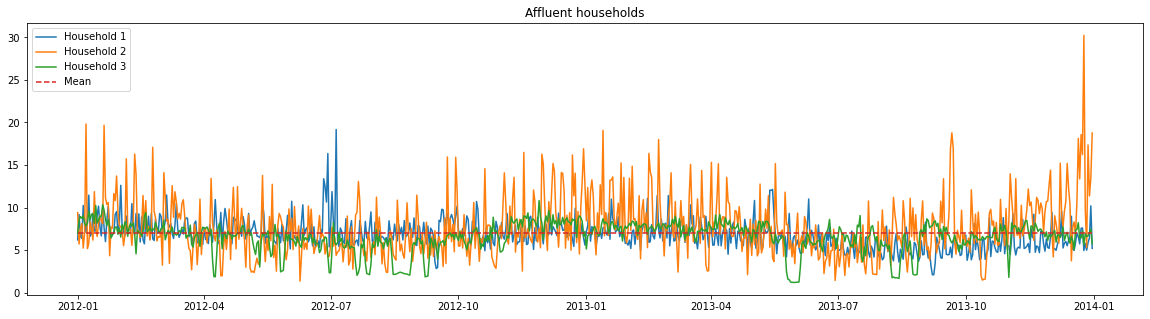

Mean energy sum is 7.032278308594816


In [ ]:
plot_households(affluent_1, affluent_2, affluent_3, "Affluent households")

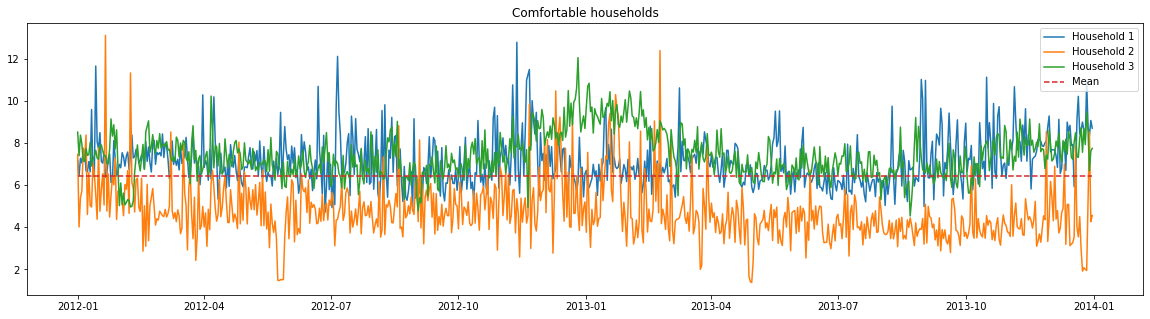

Mean energy sum is 6.428361073306048


In [ ]:
plot_households(comfortable_1, comfortable_2, comfortable_3, "Comfortable households")

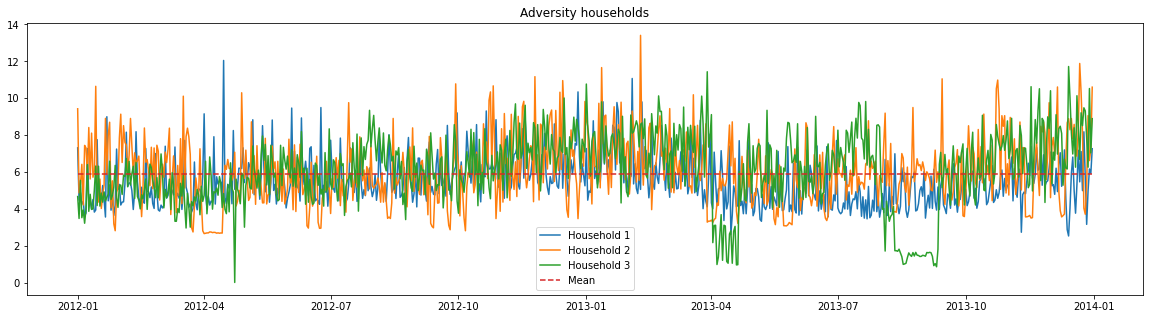

Mean energy sum is 5.861303774715778


In [ ]:
plot_households(adversity_1, adversity_2, adversity_3, "Adversity households")

In [ ]:
#Save them to .csv file for testing later
affluent_1.to_csv(full_path + '/daily/individual_households_test/affluent/household_1.csv', index=False)
affluent_2.to_csv(full_path + '/daily/individual_households_test/affluent/household_2.csv', index=False)
affluent_3.to_csv(full_path + '/daily/individual_households_test/affluent/household_3.csv', index=False)

comfortable_1.to_csv(full_path + '/daily/individual_households_test/comfortable/household_1.csv', index=False)
comfortable_2.to_csv(full_path + '/daily/individual_households_test/comfortable/household_2.csv', index=False)
comfortable_3.to_csv(full_path + '/daily/individual_households_test/comfortable/household_3.csv', index=False)

adversity_1.to_csv(full_path + '/daily/individual_households_test/adversity/household_1.csv', index=False)
adversity_2.to_csv(full_path + '/daily/individual_households_test/adversity/household_2.csv', index=False)
adversity_3.to_csv(full_path + '/daily/individual_households_test/adversity/household_3.csv', index=False)



In [ ]:
#Drop the households 
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004848"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004475"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004510"])


daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC000244"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004850"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC000239"])

daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004508"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004507"])
daily_individual_combined_consumption = filter_rows(daily_individual_combined_consumption, "LCLid", ["MAC004513"])

#Check how many unique households are left in the dataset
daily_individual_combined_consumption.LCLid.nunique()


4390

In [ ]:
#Save the file as the final dataset
#daily_individual_combined_consumption.to_csv(full_path + '/daily/daily_individual_combined_consumption_final.csv', index=False)
daily_individual_combined_consumption.to_csv(full_path + '/daily/daily_individual_consumption_final_std.csv', index=False)

## 4. Creating a grouped consumption file 

In [ ]:
#Make function to group all individual consumption of a certain dataset to get average consumption
def group_consumption (dataset):
  #Create a new column for total number of houses that recorded on a certain day 
  house_count = dataset.groupby('day')[['LCLid']].nunique()

  #Then make another column called grouped_energy to get the total electricity consumption of all households on a certain day 
  grouped_energy = dataset.groupby('day')[['energy_sum']].sum()
  grouped_energy = grouped_energy.merge(house_count, on = ['day']).reset_index()
  grouped_energy.rename(columns={'LCLid':'house_count'}, inplace=True)

  #Then get the average elctricity consumed by all households that recorded on each day 
  grouped_energy['total_energy_avg'] = grouped_energy['energy_sum']/grouped_energy['house_count']

  #Then remove the irrelevant columns that won't be needed anymore 
  dataset = dataset.drop(['LCLid', 'energy_sum'], axis=1)

  #This results in duplicate values of weather features. Drop them so that there is only one entry per day
  dataset.drop_duplicates(inplace=True)

  #Merge the existing dataset with the new one by day
  grouped_energy = grouped_energy.merge(dataset, on = ['day'])

  #Drop energy_sum as its no longer needed 
  grouped_energy.drop(['energy_sum'], axis=1, inplace=True)

  return grouped_energy


#Load in individual household consumption dataframe
daily_individual_combined_consumption = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_std.csv')


#Make date readable format
daily_individual_combined_consumption['day']=  pd.to_datetime(daily_individual_combined_consumption['day'],format='%Y-%m-%d')

In [ ]:
daily_individual_combined_consumption.shape

(2537557, 26)

### 3.1 Standard tariff vs Time of Use (ToU) on dataset

In [ ]:
daily_individual_combined_consumption.head()

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
0  MAC000241 2012-01-01      23.781            6             1      1   
1  MAC000189 2012-01-01      11.324            6             1      1   
2  MAC004552 2012-01-01       9.741            6             1      1   
3  MAC000084 2012-01-01      14.787            6             1      1   
4  MAC000237 2012-01-01      42.423            6             1      1   

   Acorn_grouped_Adversity  Acorn_grouped_Affluent  Acorn_grouped_Comfortable  \
0                      0.0                     0.0                        1.0   
1                      0.0                     1.0                        0.0   
2                      0.0                     1.0                        0.0   
3                      0.0                     1.0                        0.0   
4                      0.0                     1.0                        0.0   

   temperatureLow  temperatureHigh  dewPoint  cloudCover  windSpeed  pressure  \
0            5.18            12.56      9.45        0.58       4.92   1004.82   
1            5.18            12.56      9.45        0.58       4.92   1004.82   
2            5.18            12.56      9.45        0.58       4.92   1004.82   
3            5.18            12.56      9.45        0.58       4.92   1004.82   
4            5.18            12.56      9.45        0.58       4.92   1004.82   

   visibility  humidity  uvIndex  moonPhase  weather_type_clear-day  \
0       12.33       0.9      1.0       0.26                     0.0   
1       12.33       0.9      1.0       0.26                     0.0   
2       12.33       0.9      1.0       0.26                     0.0   
3       12.33       0.9      1.0       0.26                     0.0   
4       12.33       0.9      1.0       0.26                     0.0   

   weather_type_cloudy  weather_type_fog  weather_type_partly-cloudy-day  \
0                  0.0               0.0                             1.0   
1                  0.0               0.0                             1.0   
2                  0.0               0.0                             1.0   
3                  0.0               0.0                             1.0   
4                  0.0               0.0                             1.0   

   weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
0                               0.0                0.0               0  
1                               0.0                0.0               0  
2                               0.0                0.0               0  
3                               0.0                0.0               0  
4                               0.0                0.0               0

In [ ]:
#Get households only on standard tarrifs
#daily_standard_tarrif = daily_individual_combined_consumption[daily_individual_combined_consumption.stdorToU == 'Std']
#daily_standard_tarrif_grouped = group_consumption(daily_standard_tarrif)


#Get households only on ToU tarrifs
#daily_tou_tarrif = daily_individual_combined_consumption[daily_individual_combined_consumption.stdorToU == 'ToU']
#daily_tou_tariff_grouped = group_consumption(daily_tou_tarrif)


#Group households 
daily_standard_tarrif_grouped = group_consumption(daily_individual_combined_consumption)

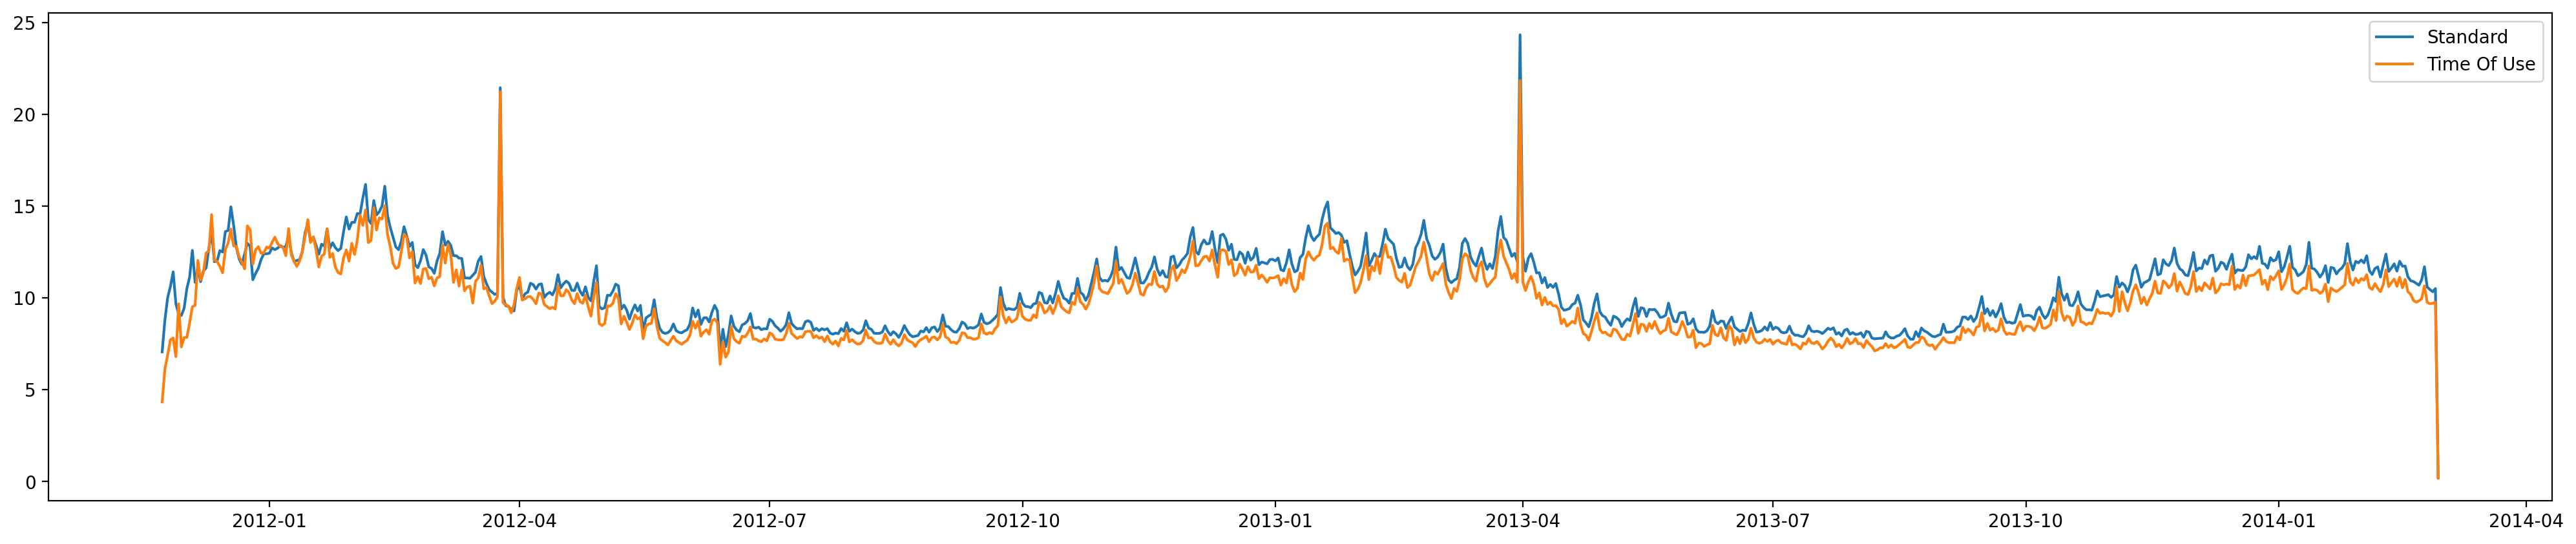

In [ ]:
#Plot graph to show difference between the two tariffs
fig, ax1 = plt.subplots(figsize = (25,5), dpi=200)
ax1.plot(daily_standard_tarrif_grouped.day, daily_standard_tarrif_grouped.total_energy_avg, label='Standard') 
ax1.plot(daily_tou_tariff_grouped.day, daily_tou_tariff_grouped.total_energy_avg, label='Time Of Use')
ax1.legend()

plt.show()

In [ ]:
#Check shape of standard consumption file 
daily_standard_tarrif.shape



(2783514, 27)

In [ ]:
#Check shape of grouped standard consumption file 
daily_standard_tarrif_grouped.shape

(2493, 27)

In [ ]:
#Drop tarrif type column
#daily_standard_tarrif.drop(['stdorToU'], axis=1, inplace=True)
#daily_standard_tarrif_grouped.drop(['stdorToU'], axis=1, inplace=True)

#Drop acorn groups in the grouped dataset
daily_standard_tarrif_grouped.drop(['Acorn_grouped_Adversity'], axis=1, inplace=True)
daily_standard_tarrif_grouped.drop(['Acorn_grouped_Affluent'], axis=1, inplace=True)
daily_standard_tarrif_grouped.drop(['Acorn_grouped_Comfortable'], axis=1, inplace=True)

#This results in duplicate values of thanks to the 3 different ACORN group features. Drop them so that there is only one entry per day
daily_standard_tarrif_grouped.drop_duplicates(inplace=True)

#Check only one entry per day exists in the grouped dataset
daily_standard_tarrif_grouped[daily_standard_tarrif_grouped.day == '2012-11-23'].head()

day  house_count  total_energy_avg  day_of_week  day_of_month  \
984 2012-11-23         4366         11.122558            4            23   

     month  temperatureLow  temperatureHigh  dewPoint  cloudCover  windSpeed  \
984     11            3.64             10.7      6.02        0.38       2.71   

     pressure  visibility  humidity  uvIndex  moonPhase  \
984   1011.69       11.46      0.89      1.0       0.34   

     weather_type_clear-day  weather_type_cloudy  weather_type_fog  \
984                     0.0                  0.0               0.0   

     weather_type_partly-cloudy-day  weather_type_partly-cloudy-night  \
984                             1.0                               0.0   

     weather_type_wind  public_holiday  
984                0.0               0

In [ ]:
#Save consumption only containing households on a standard tariff
#daily_standard_tarrif.to_csv(full_path + '/daily/daily_individual_consumption_final_std.csv', index=False)
daily_standard_tarrif_grouped.to_csv(full_path + '/daily/daily_grouped_consumption_final_std.csv', index=False)

In [ ]:
#Check how many households are still included in the dataset after selecting only standard tariffs

#daily_standard_tarrif.LCLid.nunique()

daily_individual_combined_consumption.LCLid.nunique()

4390

###3.2 Differences between ACORN types



In [ ]:
#Read in the latest .csv
daily_individual_combined_consumption = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_std.csv')

#Make date readable format
daily_individual_combined_consumption['day']=  pd.to_datetime(daily_individual_combined_consumption['day'],format='%Y-%m-%d')

In [ ]:
acorn_affluent = daily_individual_combined_consumption[daily_individual_combined_consumption.Acorn_grouped_Affluent == 1.0]
acorn_affluent_grouped = group_consumption(acorn_affluent)

acorn_comfortable = daily_individual_combined_consumption[daily_individual_combined_consumption.Acorn_grouped_Comfortable == 1.0]
acorn_comfortable_grouped = group_consumption(acorn_comfortable)

acorn_adversity = daily_individual_combined_consumption[daily_individual_combined_consumption.Acorn_grouped_Adversity == 1.0]
acorn_adversity_grouped = group_consumption(acorn_adversity)

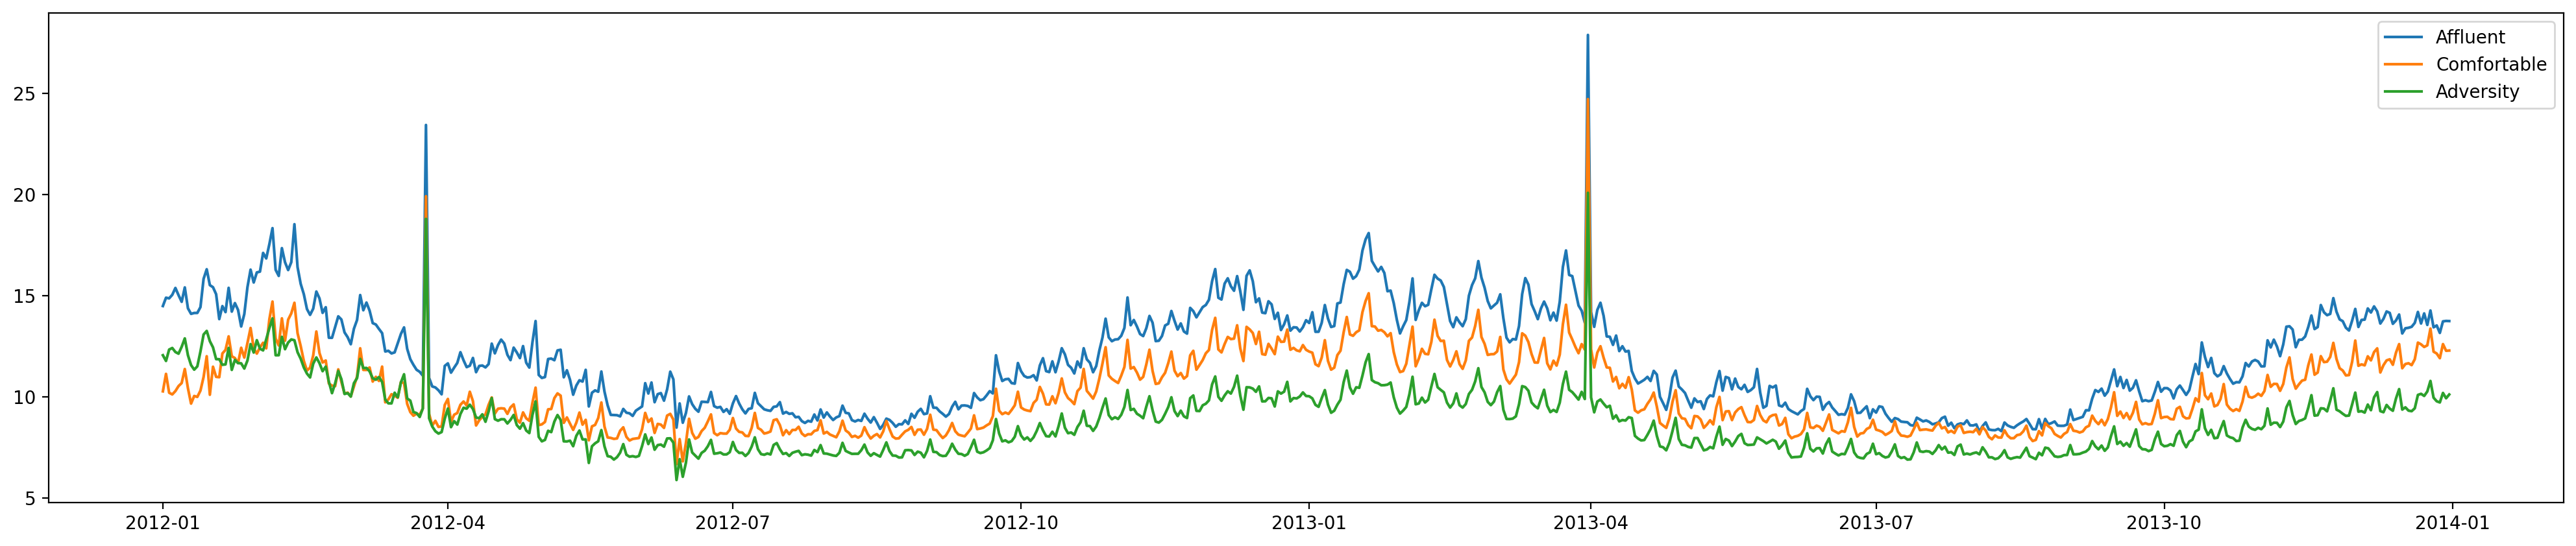

In [ ]:
#Plot graph to show difference between the two tariffs
fig, ax1 = plt.subplots(figsize = (25,5), dpi=200)

ax1.plot(acorn_affluent_grouped.day, acorn_affluent_grouped.total_energy_avg, label='Affluent')
ax1.plot(acorn_comfortable_grouped.day, acorn_comfortable_grouped.total_energy_avg, label='Comfortable') 
ax1.plot(acorn_adversity_grouped.day, acorn_adversity_grouped.total_energy_avg, label='Adversity')
ax1.legend()
plt.show()

In [ ]:
#Save each of the acorn files for future use in training later 
acorn_affluent.to_csv(full_path + '/daily/daily_individual_consumption_final_acorn_affluent.csv', index=False)
acorn_affluent_grouped.to_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_affluent.csv', index=False)
acorn_comfortable.to_csv(full_path + '/daily/daily_individual_consumption_final_acorn_comfortable.csv', index=False)
acorn_comfortable_grouped.to_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_comfortable.csv', index=False)
acorn_adversity.to_csv(full_path + '/daily/daily_individual_consumption_final_acorn_adversity.csv', index=False)
acorn_adversity_grouped.to_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_adversity.csv', index=False)

## 5. Creating train and test dataset - both all groups together and individually (8 files total) 

In [ ]:
daily_individual_combined_consumption = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_std.csv')
daily_individual_combined_consumption['day'] = pd.to_datetime(daily_individual_combined_consumption['day'], format='%Y-%m-%d')

daily_individual_combined_consumption.head()

LCLid        day  energy_sum  day_of_week  day_of_month  month  \
0  MAC000241 2012-01-01      23.781            6             1      1   
1  MAC000189 2012-01-01      11.324            6             1      1   
2  MAC004552 2012-01-01       9.741            6             1      1   
3  MAC000084 2012-01-01      14.787            6             1      1   
4  MAC000237 2012-01-01      42.423            6             1      1   

   Acorn_grouped_Adversity  Acorn_grouped_Affluent  Acorn_grouped_Comfortable  \
0                      0.0                     0.0                        1.0   
1                      0.0                     1.0                        0.0   
2                      0.0                     1.0                        0.0   
3                      0.0                     1.0                        0.0   
4                      0.0                     1.0                        0.0   

   temperatureLow  temperatureHigh  dewPoint  cloudCover  windSpeed  pressure  \
0            5.18            12.56      9.45        0.58       4.92   1004.82   
1            5.18            12.56      9.45        0.58       4.92   1004.82   
2            5.18            12.56      9.45        0.58       4.92   1004.82   
3            5.18            12.56      9.45        0.58       4.92   1004.82   
4            5.18            12.56      9.45        0.58       4.92   1004.82   

   visibility  humidity  uvIndex  moonPhase  weather_type_clear-day  \
0       12.33       0.9      1.0       0.26                     0.0   
1       12.33       0.9      1.0       0.26                     0.0   
2       12.33       0.9      1.0       0.26                     0.0   
3       12.33       0.9      1.0       0.26                     0.0   
4       12.33       0.9      1.0       0.26                     0.0   

   weather_type_cloudy  weather_type_fog  weather_type_partly-cloudy-day  \
0                  0.0               0.0                             1.0   
1                  0.0               0.0                             1.0   
2                  0.0               0.0                             1.0   
3                  0.0               0.0                             1.0   
4                  0.0               0.0                             1.0   

   weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
0                               0.0                0.0               0  
1                               0.0                0.0               0  
2                               0.0                0.0               0  
3                               0.0                0.0               0  
4                               0.0                0.0               0

In [ ]:
#Split up the dataset as train_test_split may be unpredictable and put the same household into the training dataset and the test dataset

#https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
#https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

#Now select certain households from each Acorn Group to be used for testing later
def get_households(acorn_type):
  select_households = daily_individual_combined_consumption[['LCLid', 'day', 'Acorn_grouped_Adversity',
        'Acorn_grouped_Affluent', 'Acorn_grouped_Comfortable']]

  select_households = select_households[select_households[acorn_type] == 1.0]
  select_households_grouped = select_households[['LCLid', 'day']]
  select_households_grouped = select_households_grouped.groupby(['LCLid']).count()       
  select_households_grouped.sort_values('day', ascending=False, inplace=True)
  return select_households_grouped




In [ ]:
all_unique_lclids = daily_individual_combined_consumption.drop_duplicates(subset=['LCLid'])

#Keep only the LCLid column
all_unique_lclids = all_unique_lclids['LCLid']

#Check how  many unique LCLids there are, should be 4390
all_unique_lclids.nunique()

4390

In [ ]:
#use the get_households function to get households from specific ACORN - we would ideally want to have representative split accross all groups when creating the file that contains all three groups
acorn_affluent = get_households("Acorn_grouped_Affluent")
acorn_comfortable = get_households("Acorn_grouped_Comfortable")
acorn_adversity = get_households("Acorn_grouped_Adversity")

#select random households to be part of training dataset
acorn_affluent_training = acorn_affluent.sample(frac=0.8, random_state=25)
acorn_comfortable_training = acorn_comfortable.sample(frac=0.8, random_state=25)
acorn_adversity_training = acorn_adversity.sample(frac=0.8, random_state=25)

#then drop LCLids in not included in training dataset and keep the rest for testing
acorn_affluent_testing = acorn_affluent.drop(acorn_affluent_training.index)
acorn_comfortable_testing = acorn_comfortable.drop(acorn_comfortable_training.index)
acorn_adversity_testing = acorn_adversity.drop(acorn_adversity_training.index)



In [ ]:
#Check the shape of the dataset
print('No. of training examples:', acorn_affluent_training.shape[0])
print('No. of testing examples:', acorn_affluent_testing.shape[0])


print('No. of training examples:', acorn_comfortable_training.shape[0])
print('No. of testing examples:', acorn_comfortable_testing.shape[0])


print('No. of training examples:', acorn_adversity_training.shape[0])
print('No. of testing examples:', acorn_adversity_testing.shape[0])


#Affluent
#No. of training examples: 1359
#No. of testing examples: 340

#Comfortable
#No. of training examples: 943
#No. of testing examples: 236

#Adversity
#No. of training examples: 1210
#No. of testing examples: 302

No. of training examples: 1359
No. of testing examples: 340
No. of training examples: 943
No. of testing examples: 236
No. of training examples: 1210
No. of testing examples: 302


In [ ]:
#Merge with daily consumption dataset which also contains the other features
acorn_affluent_training = daily_individual_combined_consumption.merge(acorn_affluent_training, how = 'inner', on = ['LCLid'])
acorn_affluent_testing = daily_individual_combined_consumption.merge(acorn_affluent_testing, how = 'inner', on = ['LCLid'])
acorn_comfortable_training = daily_individual_combined_consumption.merge(acorn_comfortable_training, how = 'inner', on = ['LCLid'])
acorn_comfortable_testing = daily_individual_combined_consumption.merge(acorn_comfortable_testing, how = 'inner', on = ['LCLid'])
acorn_adversity_training = daily_individual_combined_consumption.merge(acorn_adversity_training, how = 'inner', on = ['LCLid'])
acorn_adversity_testing = daily_individual_combined_consumption.merge(acorn_adversity_testing, how = 'inner', on = ['LCLid'])


In [ ]:
acorn_affluent_training.head()

LCLid      day_x  energy_sum  day_of_week  day_of_month  month  \
0  MAC004552 2012-01-01       9.741            6             1      1   
1  MAC004552 2012-01-02       9.749            0             2      1   
2  MAC004552 2012-01-03       9.647            1             3      1   
3  MAC004552 2012-01-04      47.007            2             4      1   
4  MAC004552 2012-01-05      48.555            3             5      1   

   Acorn_grouped_Adversity  Acorn_grouped_Affluent  Acorn_grouped_Comfortable  \
0                      0.0                     1.0                        0.0   
1                      0.0                     1.0                        0.0   
2                      0.0                     1.0                        0.0   
3                      0.0                     1.0                        0.0   
4                      0.0                     1.0                        0.0   

   temperatureLow  temperatureHigh  dewPoint  cloudCover  windSpeed  pressure  \
0            5.18            12.56      9.45        0.58       4.92   1004.82   
1            4.69             7.57      2.80        0.21       4.81   1008.49   
2            5.27            12.41      5.73        0.48       8.47   1003.23   
3            8.16             8.21      3.38        0.49       7.98   1014.07   
4            4.40            11.04      4.28        0.47       9.49   1004.74   

   visibility  humidity  uvIndex  moonPhase  weather_type_clear-day  \
0       12.33      0.90      1.0       0.26                     0.0   
1       13.23      0.81      1.0       0.29                     0.0   
2       10.80      0.82      1.0       0.32                     0.0   
3       12.62      0.78      1.0       0.35                     0.0   
4       12.92      0.70      1.0       0.38                     0.0   

   weather_type_cloudy  weather_type_fog  weather_type_partly-cloudy-day  \
0                  0.0               0.0                             1.0   
1                  0.0               0.0                             1.0   
2                  0.0               0.0                             0.0   
3                  0.0               0.0                             0.0   
4                  0.0               0.0                             0.0   

   weather_type_partly-cloudy-night  weather_type_wind  public_holiday  day_y  
0                               0.0                0.0               0    733  
1                               0.0                0.0               1    733  
2                               0.0                1.0               0    733  
3                               0.0                1.0               0    733  
4                               0.0                1.0               0    733

In [ ]:
#Set training for only 2012
acorn_affluent_training_final = acorn_affluent_training[(acorn_affluent_training.day_x >= '2012-01-01') & (acorn_affluent_training.day_x <= '2012-12-31')]
acorn_comfortable_training_final = acorn_comfortable_training[(acorn_comfortable_training.day_x >= '2012-01-01') & (acorn_comfortable_training.day_x <= '2012-12-31')]
acorn_adversity_training_final = acorn_adversity_training[(acorn_adversity_training.day_x >= '2012-01-01') & (acorn_adversity_training.day_x <= '2012-12-31')]


#Set testing for only 2013
acorn_affluent_testing_final = acorn_affluent_testing[(acorn_affluent_testing.day_x >= '2013-01-01') & (acorn_affluent_testing.day_x <= '2013-12-31')]
acorn_comfortable_testing_final = acorn_comfortable_testing[(acorn_comfortable_testing.day_x >= '2013-01-01') & (acorn_comfortable_testing.day_x <= '2013-12-31')]
acorn_adversity_testing_final = acorn_adversity_testing[(acorn_adversity_testing.day_x >= '2013-01-01') & (acorn_adversity_testing.day_x <= '2013-12-31')]




In [ ]:
#Check the shape of the dataset
print('No. of training examples:', acorn_affluent_training_final.LCLid.nunique())
print('No. of testing examples:', acorn_affluent_testing_final.LCLid.nunique())


print('No. of training examples:', acorn_comfortable_training_final.LCLid.nunique())
print('No. of testing examples:', acorn_comfortable_testing_final.LCLid.nunique())


print('No. of training examples:', acorn_adversity_training_final.LCLid.nunique())
print('No. of testing examples:', acorn_adversity_testing_final.LCLid.nunique())

#before  vs after
#Affluent
#No. of training examples: 1359
#No. of testing examples: 340
#--
#No. of training examples: 1357
#No. of testing examples: 337

#Comfortable
#No. of training examples: 943
#No. of testing examples: 236
#--
#No. of training examples: 942
#No. of testing examples: 235

#Adversity
#No. of training examples: 1210
#No. of testing examples: 302
#--
#No. of training examples: 1209
#No. of testing examples: 300

No. of training examples: 1357
No. of testing examples: 337
No. of training examples: 942
No. of testing examples: 235
No. of training examples: 1209
No. of testing examples: 300


In [ ]:
#Check their shapes

#Check that the merge happened correctly as well as their shapes
print('Shape of training affluent', acorn_affluent_training_final.shape)
print('Shape of testing affluent', acorn_affluent_testing_final.shape)

#Check that the merge happened correctly as well as their shapes
print('Shape of training comfortable', acorn_comfortable_training_final.shape)
print('Shape of testing comfortable', acorn_comfortable_testing_final.shape)

#Check that the merge happened correctly as well as their shapes
print('Shape of training adversity', acorn_adversity_training_final.shape)
print('Shape of testing adversity', acorn_adversity_testing_final.shape)

Shape of training affluent (328490, 27)
Shape of testing affluent (116357, 27)
Shape of training comfortable (200928, 27)
Shape of testing comfortable (82373, 27)
Shape of training adversity (268159, 27)
Shape of testing adversity (105165, 27)


In [ ]:
#Save the households to .csv files for training in models later
acorn_affluent_training_final.to_csv(full_path + '/daily/daily_affluent_training.csv', index=False)
acorn_affluent_testing_final.to_csv(full_path + '/daily/daily_affluent_testing.csv', index=False)

acorn_comfortable_training_final.to_csv(full_path + '/daily/daily_comfortable_training.csv', index=False)
acorn_comfortable_testing_final.to_csv(full_path + '/daily/daily_comfortable_testing.csv', index=False)

acorn_adversity_training_final.to_csv(full_path + '/daily/daily_adversity_training.csv', index=False)
acorn_adversity_testing_final.to_csv(full_path + '/daily/daily_adversity_testing.csv', index=False)


In [ ]:
#Then, combine each of the training and testing acorn split groups into one
training_df = acorn_affluent_training_final.append(acorn_comfortable_training_final)
training_df_final = training_df.append(acorn_adversity_training_final)


testing_df = acorn_affluent_testing_final.append(acorn_comfortable_testing_final)
testing_df_final = testing_df.append(acorn_adversity_testing_final)


print(training_df_final.shape)
print(testing_df_final.shape)

(797577, 27)
(303895, 27)


In [ ]:
#Make testing and training dataframes and then save to .csv file 
#training_df_final = daily_individual_combined_consumption.merge(training_df, how = 'inner', on = ['LCLid'])
#testing_df_final = daily_individual_combined_consumption.merge(testing_df, how = 'inner', on = ['LCLid'])

#Check that the merge happened correctly as well as their shapes
print('Number of training LCLids', training_df_final.LCLid.nunique())
print('Number of testing LCLids', testing_df_final.LCLid.nunique())

#Check that the merge happened correctly as well as their shapes
print('Shape of training dataset', training_df_final.shape)
print('Shape of testing dataset', testing_df_final.shape)

#Then save to .CSV files
training_df_final.to_csv(full_path + '/daily/daily_individual_consumption_final_training.csv', index=False)
testing_df_final.to_csv(full_path + '/daily/daily_individual_consumption_final_testing.csv', index=False)

Number of training LCLids 3508
Number of testing LCLids 872
Shape of training dataset (797577, 27)
Shape of testing dataset (303895, 27)


## 6. Trend analysis (Graphical)

In [ ]:
#Load each of the finalised files 

daily_individual_consumption = pd.read_csv(full_path + '/daily/daily_individual_consumption_final.csv')

daily_grouped_consumption = pd.read_csv(full_path + '/daily/daily_grouped_consumption_final_std.csv')

NameError: ignored

###6.1 Overview of both datasets

In [ ]:
#Check each structures

daily_individual_consumption.head()

LCLid         day  energy_sum  day_of_week  day_of_month  month  \
0  MAC000149  2011-11-23       2.287            2            23     11   
1  MAC000154  2011-11-23       5.798            2            23     11   
2  MAC000156  2011-11-23       6.523            2            23     11   
3  MAC000150  2011-11-23       9.254            2            23     11   
4  MAC000157  2011-11-23       7.408            2            23     11   

   Acorn_grouped_Adversity  Acorn_grouped_Affluent  Acorn_grouped_Comfortable  \
0                      0.0                     0.0                        1.0   
1                      1.0                     0.0                        0.0   
2                      0.0                     0.0                        1.0   
3                      0.0                     1.0                        0.0   
4                      0.0                     0.0                        1.0   

   temperatureLow  temperatureHigh  dewPoint  cloudCover  windSpeed  pressure  \
0            8.24            10.36      6.29        0.36       2.04   1027.12   
1            8.24            10.36      6.29        0.36       2.04   1027.12   
2            8.24            10.36      6.29        0.36       2.04   1027.12   
3            8.24            10.36      6.29        0.36       2.04   1027.12   
4            8.24            10.36      6.29        0.36       2.04   1027.12   

   visibility  humidity  uvIndex  moonPhase  weather_type_clear-day  \
0        8.06      0.93      1.0       0.94                     0.0   
1        8.06      0.93      1.0       0.94                     0.0   
2        8.06      0.93      1.0       0.94                     0.0   
3        8.06      0.93      1.0       0.94                     0.0   
4        8.06      0.93      1.0       0.94                     0.0   

   weather_type_cloudy  weather_type_fog  weather_type_partly-cloudy-day  \
0                  0.0               1.0                             0.0   
1                  0.0               1.0                             0.0   
2                  0.0               1.0                             0.0   
3                  0.0               1.0                             0.0   
4                  0.0               1.0                             0.0   

   weather_type_partly-cloudy-night  weather_type_wind  public_holiday  
0                               0.0                0.0               0  
1                               0.0                0.0               0  
2                               0.0                0.0               0  
3                               0.0                0.0               0  
4                               0.0                0.0               0

In [ ]:
daily_grouped_consumption.head()

day  house_count  total_energy_avg  day_of_week  day_of_month  \
0  2011-11-23            9          7.055222            2            23   
1  2011-11-23            9          7.055222            2            23   
2  2011-11-23            9          7.055222            2            23   
3  2011-11-24           18          8.784167            3            24   
4  2011-11-24           18          8.784167            3            24   

   month  Acorn_grouped_Adversity  Acorn_grouped_Affluent  \
0     11                      0.0                     0.0   
1     11                      1.0                     0.0   
2     11                      0.0                     1.0   
3     11                      0.0                     1.0   
4     11                      1.0                     0.0   

   Acorn_grouped_Comfortable  temperatureLow  temperatureHigh  dewPoint  \
0                        1.0            8.24            10.36      6.29   
1                        0.0            8.24            10.36      6.29   
2                        0.0            8.24            10.36      6.29   
3                        0.0            9.71            12.93      8.56   
4                        0.0            9.71            12.93      8.56   

   cloudCover  windSpeed  pressure  visibility  humidity  uvIndex  moonPhase  \
0        0.36       2.04   1027.12        8.06      0.93      1.0       0.94   
1        0.36       2.04   1027.12        8.06      0.93      1.0       0.94   
2        0.36       2.04   1027.12        8.06      0.93      1.0       0.94   
3        0.41       4.04   1027.22       10.64      0.89      1.0       0.97   
4        0.41       4.04   1027.22       10.64      0.89      1.0       0.97   

   weather_type_clear-day  weather_type_cloudy  weather_type_fog  \
0                     0.0                  0.0               1.0   
1                     0.0                  0.0               1.0   
2                     0.0                  0.0               1.0   
3                     0.0                  0.0               0.0   
4                     0.0                  0.0               0.0   

   weather_type_partly-cloudy-day  weather_type_partly-cloudy-night  \
0                             0.0                               0.0   
1                             0.0                               0.0   
2                             0.0                               0.0   
3                             0.0                               1.0   
4                             0.0                               1.0   

   weather_type_wind  public_holiday  
0                0.0               0  
1                0.0               0  
2                0.0               0  
3                0.0               0  
4                0.0               0

In [ ]:
daily_grouped_consumption.columns

Index(['day', 'house_count', 'total_energy_avg', 'day_of_week', 'day_of_month',
       'month', 'Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
       'Acorn_grouped_Comfortable', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday'],
      dtype='object')

### 6.2 Number of houses that had a reading during the dataset period 

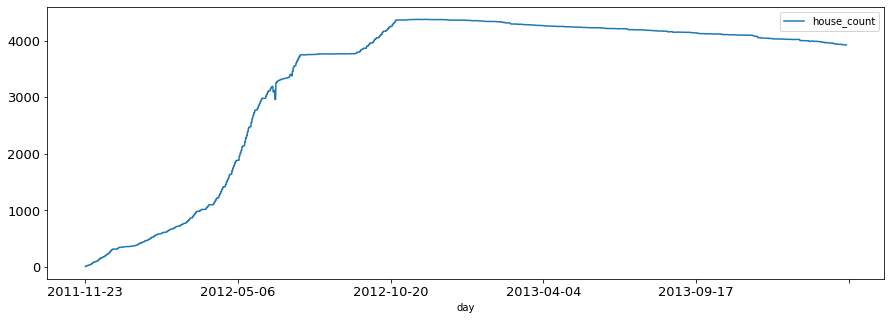

In [ ]:
#Plot the number of houses that recorded each day 

#plt.plot(daily_grouped_consumption.day, daily_grouped_consumption.house_count)

daily_grouped_consumption.plot('day', 'house_count', figsize=(15, 5), fontsize=13)
#plt.legend(fontsize = 20)


In [ ]:
#Function to create a graph against features

daily_grouped_consumption['day']=  pd.to_datetime(daily_grouped_consumption['day'],format='%Y-%m-%d').dt.date

plt.rcParams.update({'font.size': 16})

def create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label):
  fig, ax1 = plt.subplots(figsize = (25,5), dpi=200)

  #Plot day against avg energy per household
  ax1.plot(daily_grouped_consumption.day, daily_grouped_consumption.total_energy_avg, color = 'tab:blue', label='Energy consumption')
  ax1.set_ylabel('Average Energy per Household', color = 'black')
  ax1.set_xlabel('Day', color = 'black', fontsize=13)

  #Plot second axis
  ax2 = ax1.twinx()
  ax2.plot(daily_grouped_consumption.day, feature_1, color='tab:orange', label=label_1)
  if(feature_2_true):
    ax2.plot(daily_grouped_consumption.day, feature_2, color='tab:pink', label=label_2)
  
  ax2.set_ylabel(y_label)
  ax2.legend()
 
  #ax2.legend(bbox_to_anchor=(0.0, -2.02, 1.0, 0.102))
  fig.tight_layout()
  ax1.xaxis_date()
  #ax.xaxis_date()
  #fig.autofmt_xdate()
  plt.title(title)
  plt.show()

### 6.3 Consumption vs Temperature

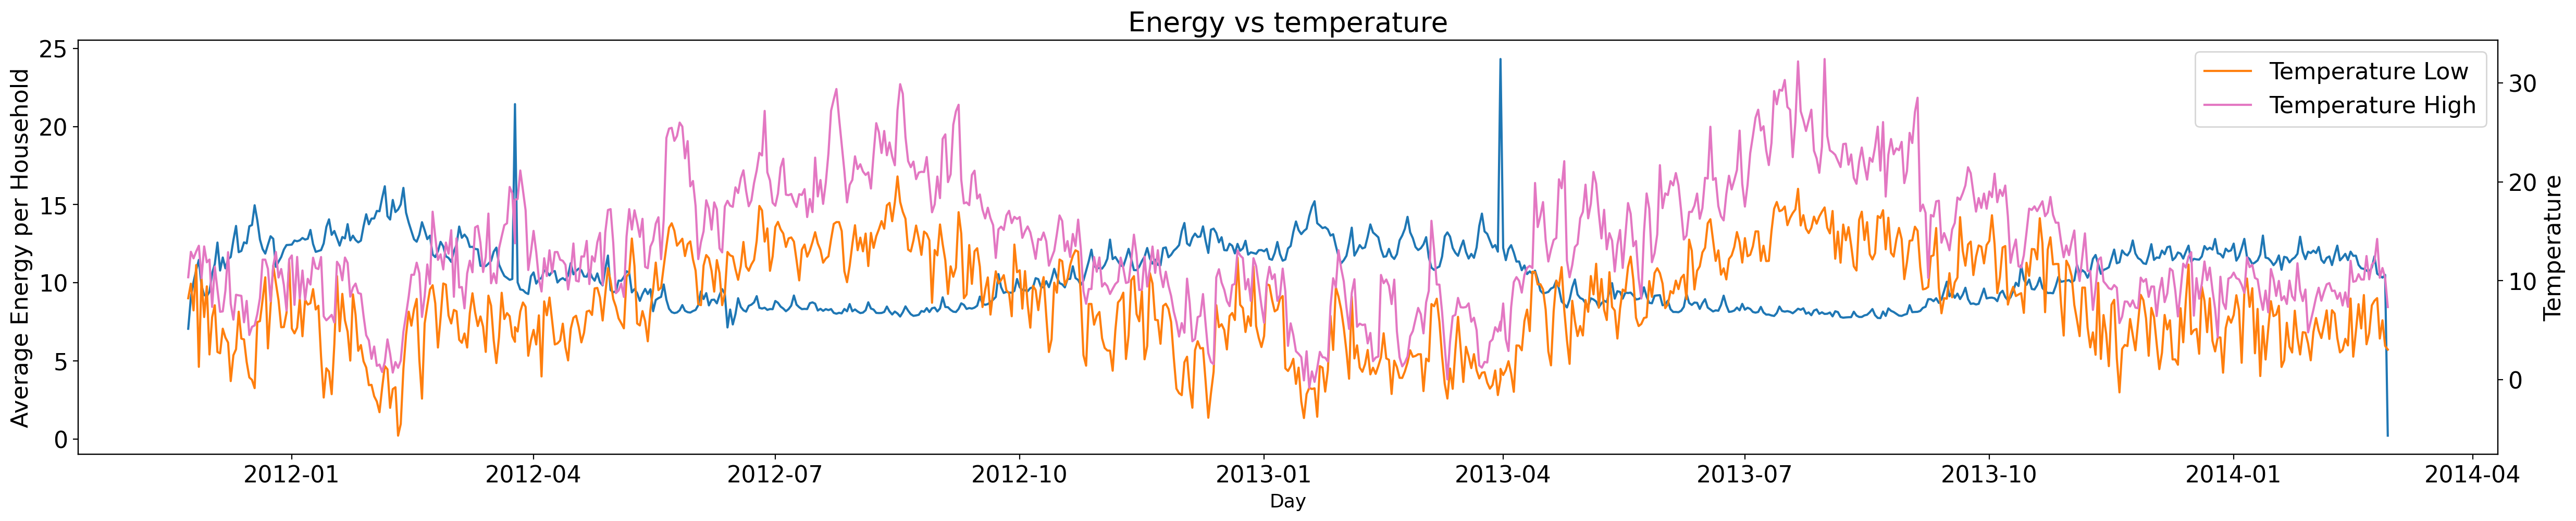

In [ ]:
title = 'Energy vs temperature'
feature_1 = daily_grouped_consumption.temperatureLow 
label_1 = 'Temperature Low' 
feature_2_true = True 
feature_2 = daily_grouped_consumption.temperatureHigh 
label_2 = 'Temperature High' 
y_label = 'Temperature'

create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label)

### 6.4 Consumption vs Cloud cover

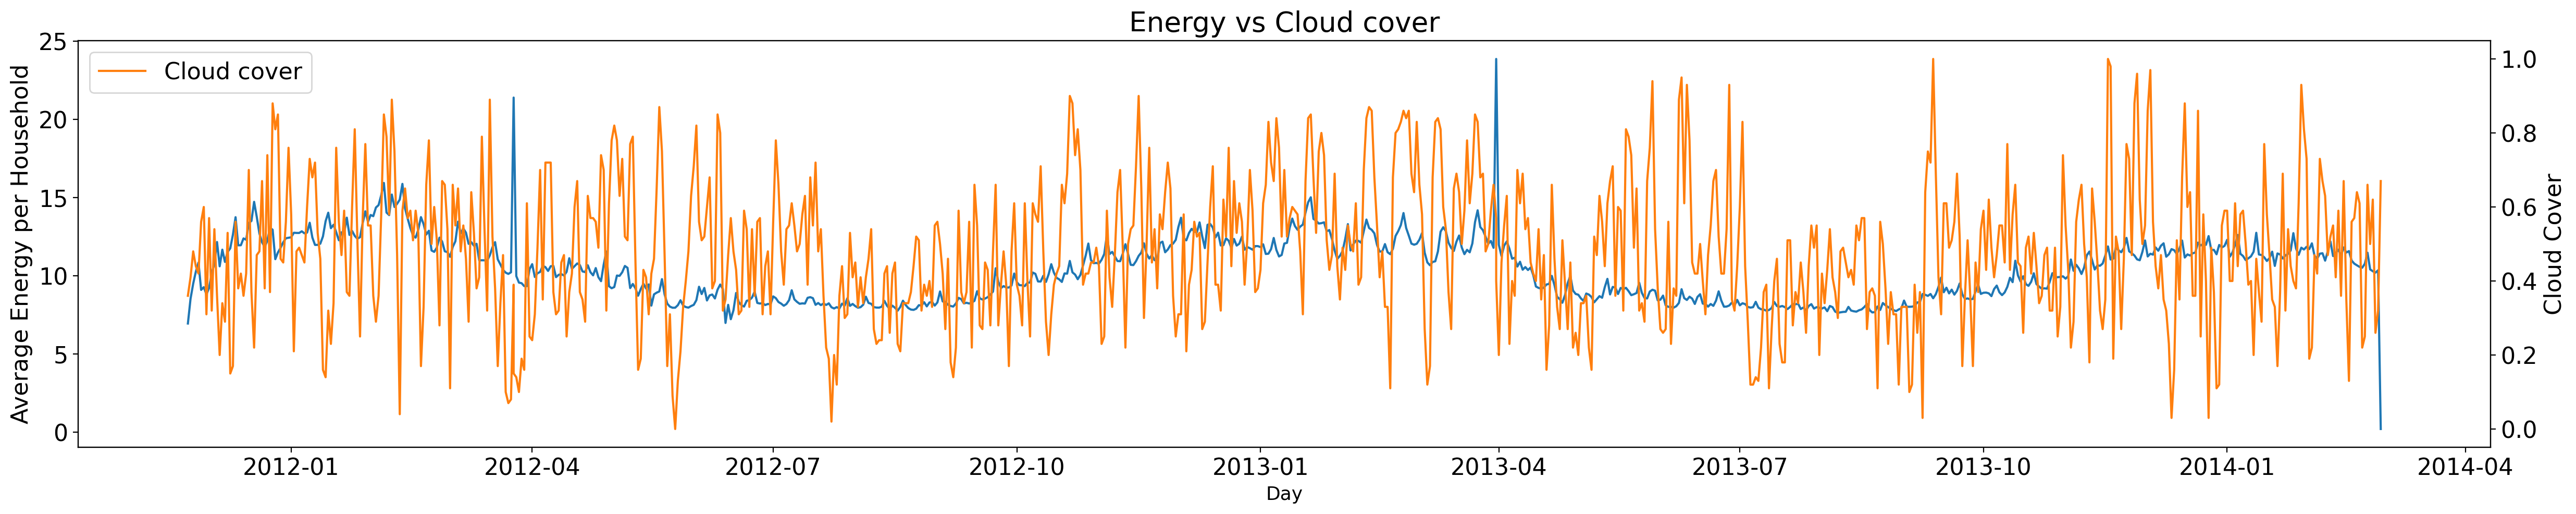

In [ ]:
title = 'Energy vs Cloud cover'
feature_1 = daily_grouped_consumption.cloudCover 
label_1 = 'Cloud cover' 
feature_2_true = False 
feature_2 = 0
label_2 = 0
y_label = 'Cloud Cover'

create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label)

###6.5 Consumption vs pressure

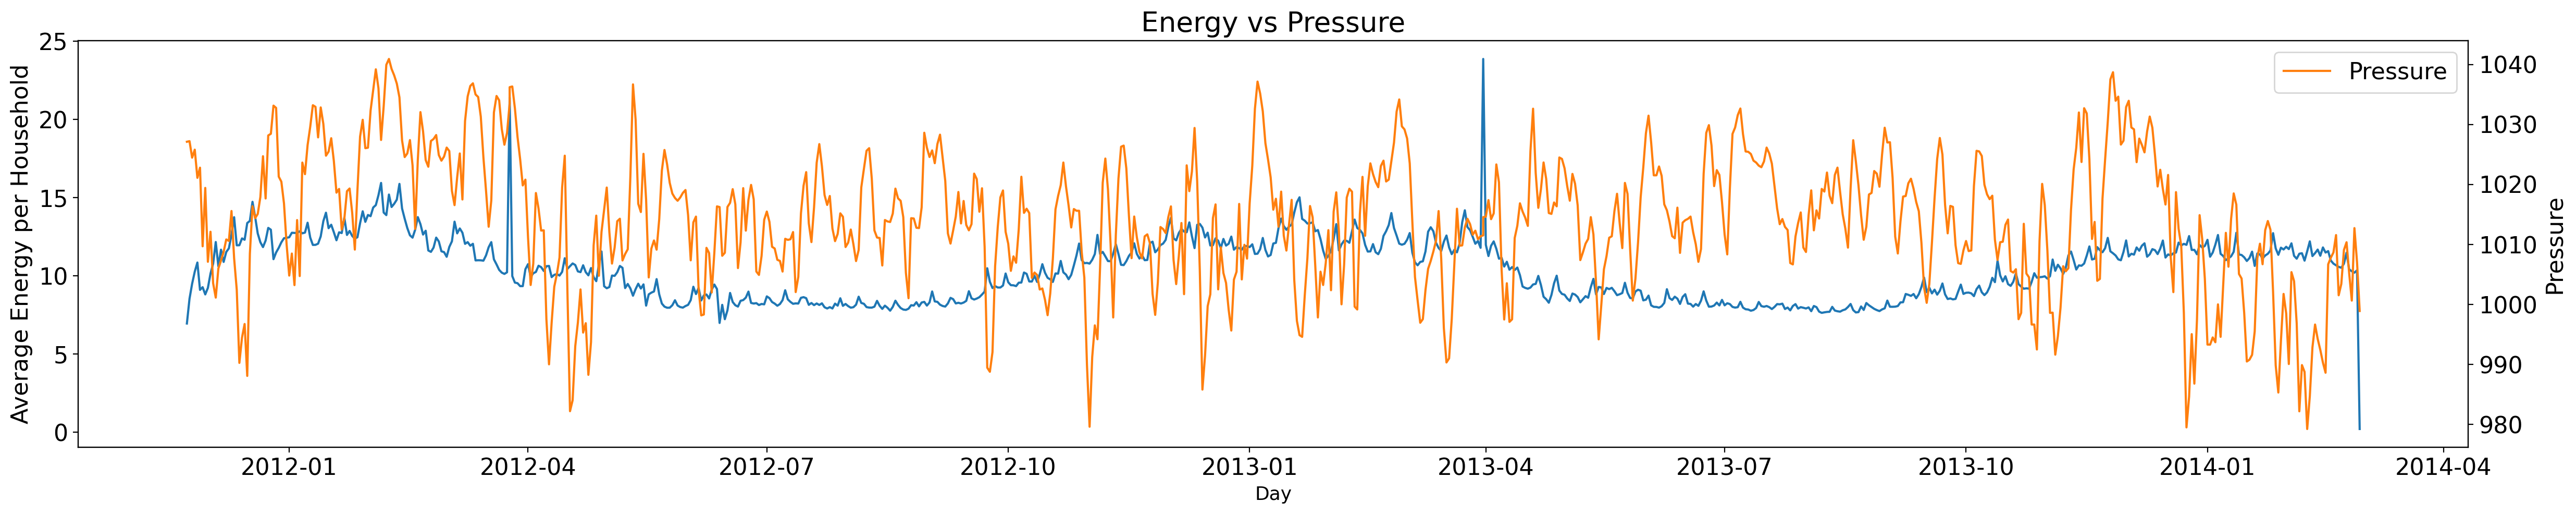

In [ ]:
title = 'Energy vs Pressure'
feature_1 = daily_grouped_consumption.pressure 
label_1 = 'Pressure' 
feature_2_true = False 
feature_2 = 0
label_2 = 0
y_label = 'Pressure'

create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label)

### 6.6 Consumption vs Humidity

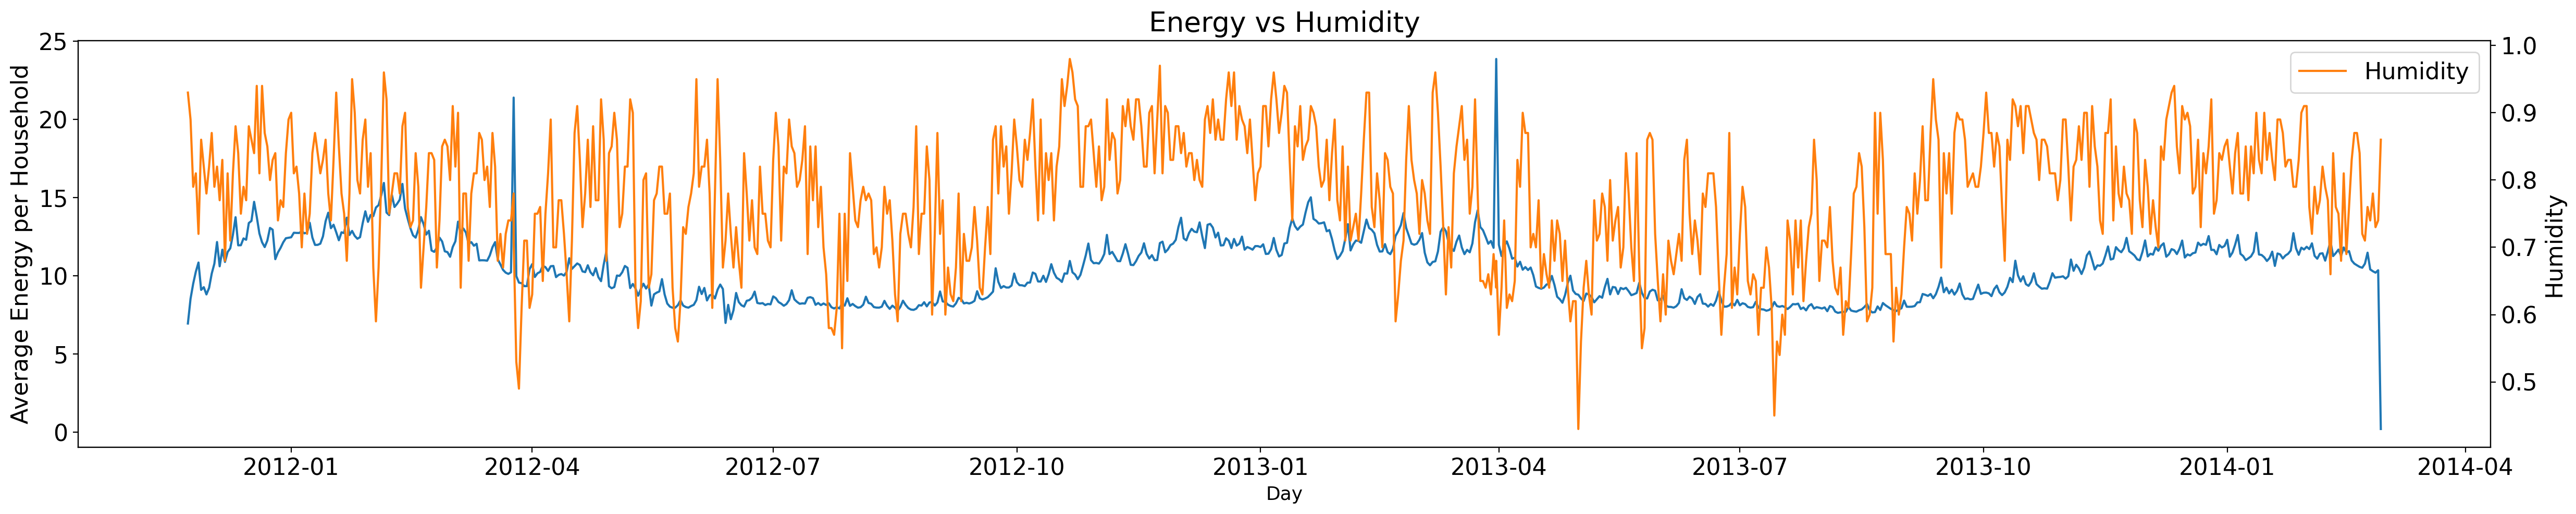

In [ ]:
title = 'Energy vs Humidity'
feature_1 = daily_grouped_consumption.humidity 
label_1 = 'Humidity' 
feature_2_true = False 
feature_2 = 0
label_2 = 0
y_label = 'Humidity'

create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label)

### 6.6 Consumption vs UV Index

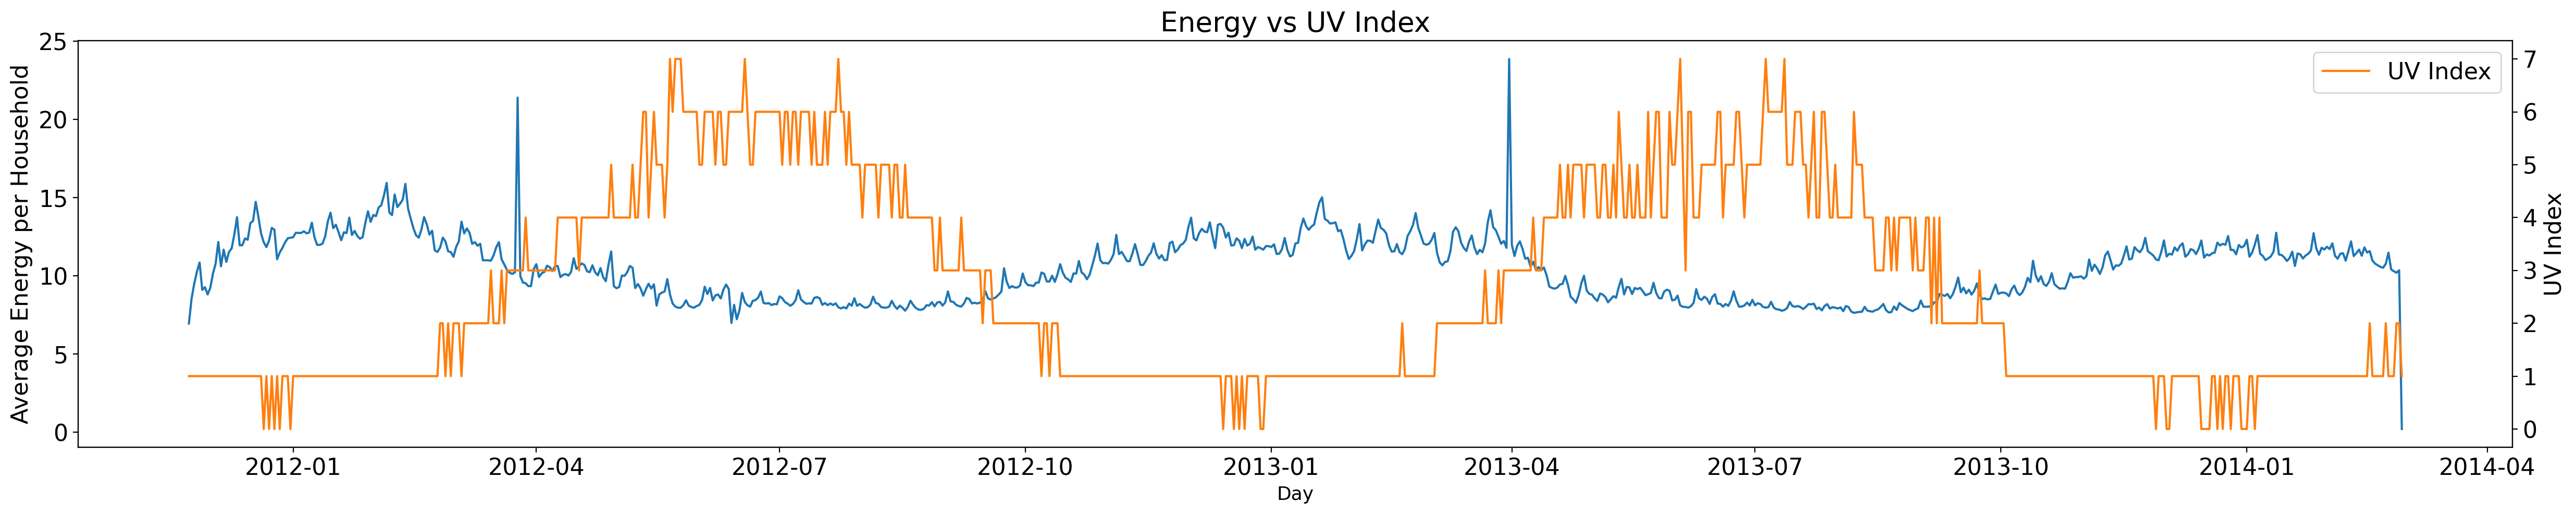

In [ ]:
title = 'Energy vs UV Index'
feature_1 = daily_grouped_consumption.uvIndex 
label_1 = 'UV Index' 
feature_2_true = False 
feature_2 = 0
label_2 = 0
y_label = 'UV Index'

create_graph(title, feature_1, label_1, feature_2_true, feature_2, label_2, y_label)

##7. Trend analysis (correlation) heatmap

In [ ]:
#Load each of the finalised files 

daily_individual_consumption = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_training.csv')
daily_grouped_consumption = pd.read_csv(full_path + '/daily/daily_grouped_consumption_final.csv')

acorn_affluent = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_acorn_affluent.csv')
acorn_affluent_grouped = pd.read_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_affluent.csv')

acorn_comfortable = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_acorn_comfortable.csv')
acorn_comfortable_grouped = pd.read_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_comfortable.csv')

acorn_adversity = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_acorn_adversity.csv')
acorn_adversity_grouped = pd.read_csv(full_path + '/daily/daily_grouped_consumption_final_acorn_adversity.csv')


FileNotFoundError: ignored

### 7.1 Grouped consumption columns

In [ ]:
daily_grouped_consumption.columns

NameError: ignored

In [ ]:
#Group consumption columns

#All features
grouped_features = ['total_energy_avg', 'day_of_week', 'day_of_month',
       'month', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday']

grouped_numerical_features = ['total_energy_avg', 'temperatureLow',
       'temperatureHigh', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'visibility', 'humidity', 'uvIndex', 'moonPhase',
       'weather_type_clear-day', 'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind']

grouped_categorical_features = ['total_energy_avg', 'weather_type_clear-day', 'weather_type_cloudy',
       'weather_type_fog', 'weather_type_partly-cloudy-day',
       'weather_type_partly-cloudy-night', 'weather_type_wind',
       'public_holiday']

### 7.2 Individual consumption columns

In [ ]:
daily_individual_consumption.shape

(2537557, 26)

In [ ]:
daily_individual_consumption.columns

Index(['LCLid', 'day', 'energy_sum', 'day_of_week', 'day_of_month', 'month',
       'Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
       'Acorn_grouped_Comfortable', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday'],
      dtype='object')

In [ ]:
#All Individual consumption columns
individual_features = ['energy_sum', 'day_of_week', 'day_of_month',
       'month', 'Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
       'Acorn_grouped_Comfortable', 'temperatureLow', 'temperatureHigh',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'visibility',
       'humidity', 'uvIndex', 'moonPhase', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday']

#Just numerical features
individual_numerical_features = ['energy_sum', 'temperatureLow',
       'temperatureHigh', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'visibility', 'humidity', 'uvIndex', 'moonPhase']


#Just categorical features
individual_categorical_features = ['Acorn_grouped_Adversity', 'Acorn_grouped_Affluent',
       'Acorn_grouped_Comfortable', 'weather_type_clear-day',
       'weather_type_cloudy', 'weather_type_fog',
       'weather_type_partly-cloudy-day', 'weather_type_partly-cloudy-night',
       'weather_type_wind', 'public_holiday']



#'day_of_week', 'day_of_month', 'month',
#https://towardsdatascience.com/learn-how-to-do-feature-selection-the-right-way-61bca8557bef
#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

###7.1 Grouped correlation

#### With all features

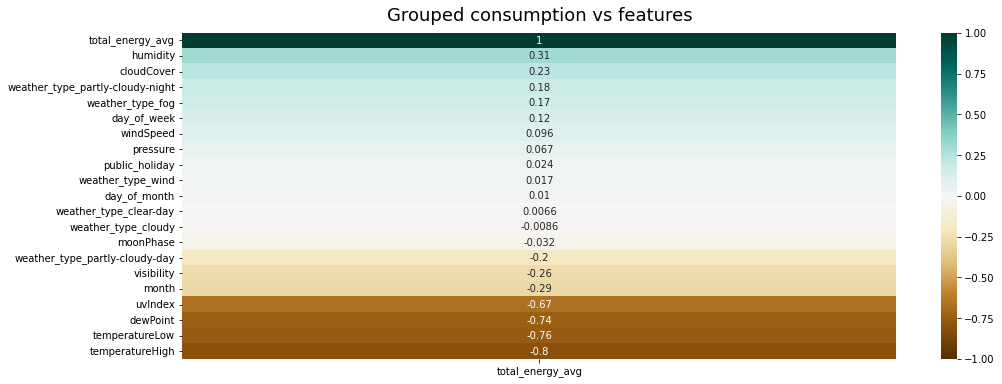

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(daily_grouped_consumption[grouped_features].corr()[['total_energy_avg']].sort_values(by='total_energy_avg', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Grouped consumption vs features', fontdict={'fontsize':18}, pad=12);




#### Affluent consumption vs features

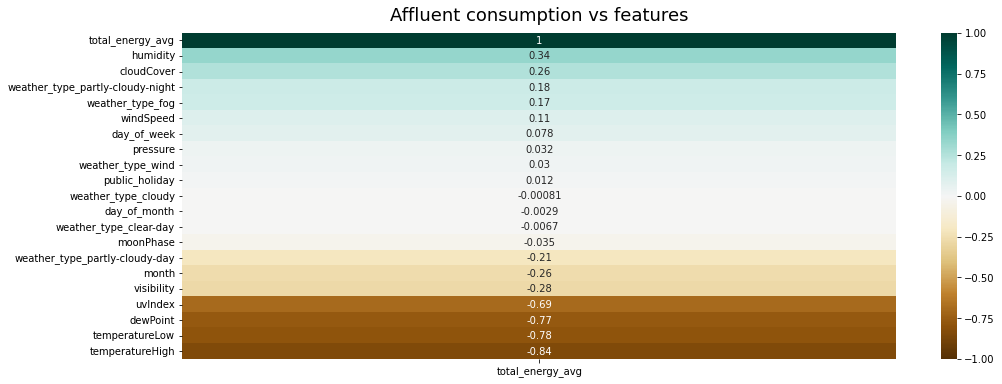

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(acorn_affluent_grouped[grouped_features].corr()[['total_energy_avg']].sort_values(by='total_energy_avg', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Affluent consumption vs features', fontdict={'fontsize':18}, pad=12);

#### Comfortable consumption vs features

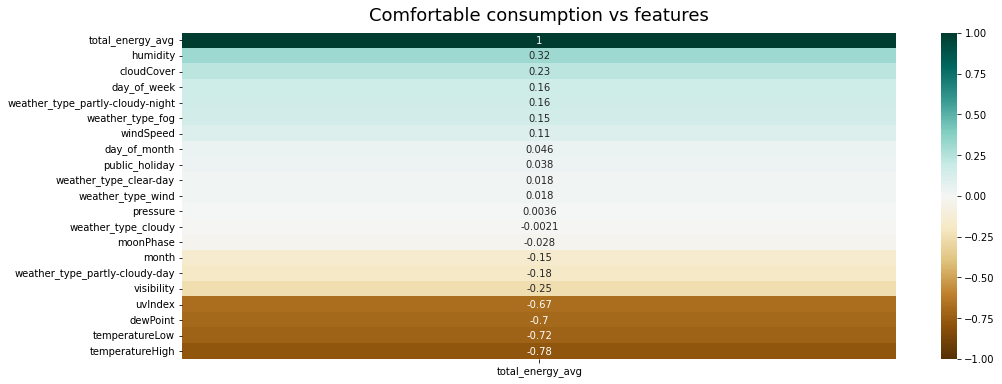

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(acorn_comfortable_grouped[grouped_features].corr()[['total_energy_avg']].sort_values(by='total_energy_avg', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Comfortable consumption vs features', fontdict={'fontsize':18}, pad=12);

#### Adversity consumption vs features

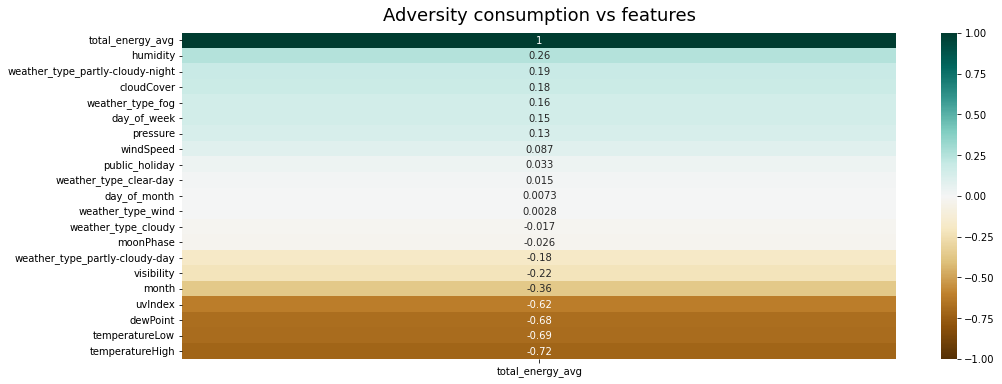

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(acorn_adversity_grouped[grouped_features].corr()[['total_energy_avg']].sort_values(by='total_energy_avg', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Adversity consumption vs features', fontdict={'fontsize':18}, pad=12);

###7.2 Individual correlation

#### With all features

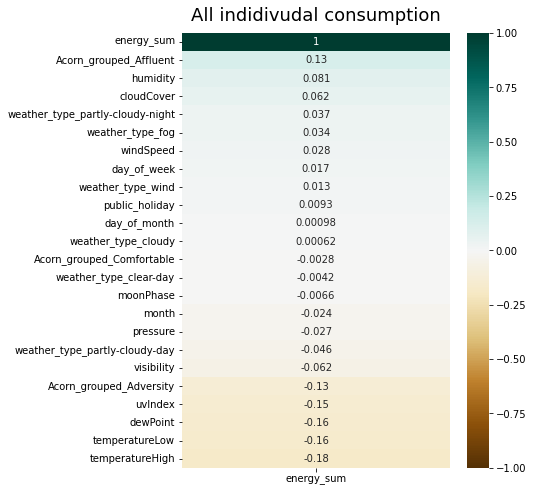

In [ ]:
plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(daily_individual_consumption[individual_features].corr()[['energy_sum']].sort_values(by='energy_sum', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('All indidivudal consumption', fontdict={'fontsize':18}, pad=12);

#### Affluent consumption vs features

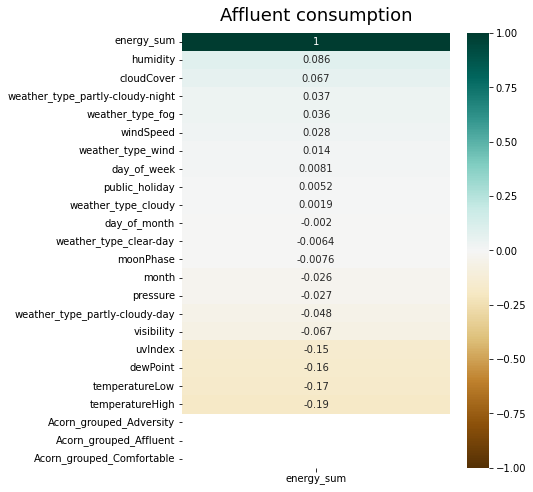

In [ ]:
plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(acorn_affluent[individual_features].corr()[['energy_sum']].sort_values(by='energy_sum', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Affluent consumption', fontdict={'fontsize':18}, pad=12);

#### Comfortable consumption vs features

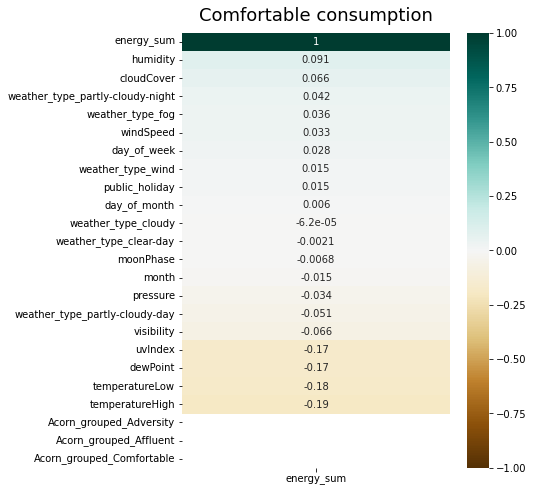

In [ ]:
plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(acorn_comfortable[individual_features].corr()[['energy_sum']].sort_values(by='energy_sum', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Comfortable consumption', fontdict={'fontsize':18}, pad=12);

#### Adversity consumption vs features

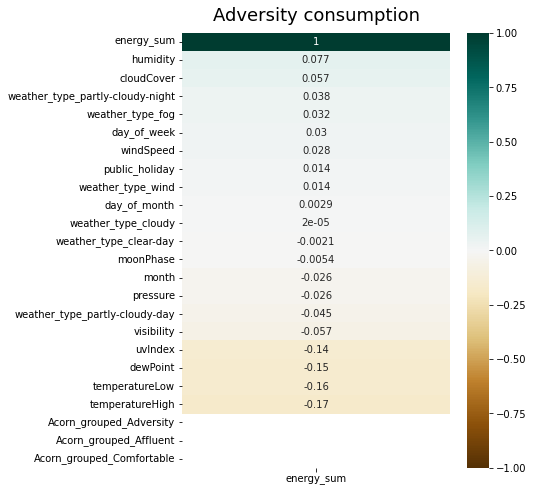

In [ ]:
plt.figure(figsize=(6, 8))
heatmap = sns.heatmap(acorn_adversity[individual_features].corr()[['energy_sum']].sort_values(by='energy_sum', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Adversity consumption', fontdict={'fontsize':18}, pad=12);

###7.3 Individual correlation - Mutual information

####For all individual consumption

In [ ]:
#Import the training and testing dataset

X_train = pd.read_csv(full_path + '/daily/daily_individual_consumption_final_training.csv')
X_train = X_train[individual_features]
y_train = X_train.pop('energy_sum')


#Get the best 8 features that are related to predicting energy sum
selector = SelectKBest(mutual_info_regression, k=9)
train = selector.fit_transform(X_train, y_train)

train.shape


(797577, 9)

In [ ]:
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature name', 'Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Scores', 'Feature name'], ascending = [False, True])
print(ns_df_sorted)

             Feature name    Scores
4                dewPoint  0.026561
3         temperatureHigh  0.026387
0                   month  0.025686
2          temperatureLow  0.025472
6                pressure  0.023209
5               windSpeed  0.019747
8                 uvIndex  0.018390
7              visibility  0.015709
1  Acorn_grouped_Affluent  0.013212


In [ ]:
#Check what the best 8 columns were for use in future 
#https://www.rasgoml.com/feature-engineering-tutorials/feature-selection-using-mutual-information-in-scikit-learn

cols = selector.get_support(indices=True)
selected_columns = X_train.iloc[:,cols].columns.tolist()
selected_columns

['month',
 'Acorn_grouped_Affluent',
 'temperatureLow',
 'temperatureHigh',
 'dewPoint',
 'windSpeed',
 'pressure',
 'visibility',
 'uvIndex']

####For affluent acorn group consumption

In [ ]:
#Import the training and testing dataset

X_train = pd.read_csv(full_path + '/daily/daily_affluent_training.csv')
X_train = X_train[individual_features]
y_train = X_train.pop('energy_sum')


#Get the best 8 features that are related to predicting energy sum
selector = SelectKBest(mutual_info_regression, k=9)
train = selector.fit_transform(X_train, y_train)

train.shape


(328490, 9)

In [ ]:
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature name', 'Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Scores', 'Feature name'], ascending = [False, True])
print(ns_df_sorted)

      Feature name    Scores
0            month  0.028040
3         dewPoint  0.025104
1   temperatureLow  0.025092
2  temperatureHigh  0.025074
8          uvIndex  0.021918
5         pressure  0.018425
4        windSpeed  0.016760
6       visibility  0.014666
7         humidity  0.012375


In [ ]:
cols = selector.get_support(indices=True)
selected_columns = X_train.iloc[:,cols].columns.tolist()
selected_columns

['month',
 'temperatureLow',
 'temperatureHigh',
 'dewPoint',
 'windSpeed',
 'pressure',
 'visibility',
 'humidity',
 'uvIndex']

####For comfortable acorn group consumption

In [ ]:
#Import the training and testing dataset

X_train = pd.read_csv(full_path + '/daily/daily_comfortable_training.csv')
X_train = X_train[individual_features]
y_train = X_train.pop('energy_sum')


#Get the best 8 features that are related to predicting energy sum
selector = SelectKBest(mutual_info_regression, k=9)
train = selector.fit_transform(X_train, y_train)

train.shape


(200928, 9)

In [ ]:
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature name', 'Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Scores', 'Feature name'], ascending = [False, True])
print(ns_df_sorted)

      Feature name    Scores
0            month  0.035340
2  temperatureHigh  0.034368
1   temperatureLow  0.030599
3         dewPoint  0.030046
8          uvIndex  0.028778
5         pressure  0.024097
4        windSpeed  0.022941
7         humidity  0.018933
6       visibility  0.018581


In [ ]:
cols = selector.get_support(indices=True)
selected_columns = X_train.iloc[:,cols].columns.tolist()
selected_columns

['month',
 'temperatureLow',
 'temperatureHigh',
 'dewPoint',
 'windSpeed',
 'pressure',
 'visibility',
 'humidity',
 'uvIndex']

####For adversity acorn group consumption

In [ ]:
#Import the training and testing dataset

X_train = pd.read_csv(full_path + '/daily/daily_adversity_training.csv')
X_train = X_train[individual_features]
y_train = X_train.pop('energy_sum')


#Get the best 8 features that are related to predicting energy sum
selector = SelectKBest(mutual_info_regression, k=9)
train = selector.fit_transform(X_train, y_train)

train.shape


(268159, 9)

In [ ]:
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature name', 'Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Scores', 'Feature name'], ascending = [False, True])
print(ns_df_sorted)

      Feature name    Scores
0            month  0.030166
2  temperatureHigh  0.027577
3         dewPoint  0.024777
1   temperatureLow  0.023567
5         pressure  0.020758
8          uvIndex  0.019946
4        windSpeed  0.018771
6       visibility  0.013928
7         humidity  0.012149


In [ ]:
cols = selector.get_support(indices=True)
selected_columns = X_train.iloc[:,cols].columns.tolist()
selected_columns

['month',
 'temperatureLow',
 'temperatureHigh',
 'dewPoint',
 'windSpeed',
 'pressure',
 'visibility',
 'humidity',
 'uvIndex']